# Starting from 100

### Reload the data for simplicity

In [1]:

# Function to normalize dates relative to an election date
import pandas as pd
import os
from datetime import datetime, timedelta
import numpy as np

# Load the elections data
elections_df = pd.read_csv('DATA/Initial Data.csv')
# Main processing
all_dfs = []
csv_directory = 'DATA/INDICES/'
output_directory = 'DATA/OUTPUT/'

# Function to normalize dates relative to an election date
def normalize_dates(df, election_date):
    df['NormalizedDate'] = (df['Date'] - election_date).dt.days
    return df[(df['NormalizedDate'] >= -90) & (df['NormalizedDate'] <= 90)]

# Function to clean price data
def clean_price(price):
    if isinstance(price, str):
        return float(price.replace(',', ''))
    return float(price)

# Function to load and process index data
def process_index(file_path, election_date, index_name, election_name):
    df = pd.read_csv(file_path)
    df['Date'] = pd.to_datetime(df['Date'])
    df['Price'] = df['Price'].apply(clean_price)
    df = df.sort_values('Date')
   
    normalized_df = normalize_dates(df, election_date)
    if not normalized_df.empty:
        # Get the price at day -90 or the earliest available day
        start_date = normalized_df['NormalizedDate'].min()
        start_price = normalized_df.loc[normalized_df['NormalizedDate'] == start_date, 'Price'].iloc[0]
        normalized_df = normalized_df.copy()
        # Set the start price to 100 and adjust all other prices accordingly
        normalized_df['Price'] = normalized_df['Price'].apply(lambda x: (x / start_price) * 100)
        
        column_name = f"{election_name}_{index_name}"
        return normalized_df[['NormalizedDate', 'Price']].rename(columns={'Price': column_name})
    return None

for _, election in elections_df.iterrows():
    index_name = election['Index']
    election_date = pd.to_datetime(election['Date 1'])
    election_name = f"{election['Year']}_{election['Elections']}"
    filep = csv_directory + index_name + ".csv"
    file_path = os.path.abspath(filep)
    print(file_path)
    if os.path.exists(file_path):
        processed_df = process_index(file_path, election_date, index_name, election_name)
        if processed_df is not None:
            all_dfs.append(processed_df)
    else:
        print(f"Warning: File not found for index {index_name}")

if all_dfs:
    merged_df = all_dfs[0]
    for df in all_dfs[1:]:
        merged_df = pd.merge(merged_df, df, on='NormalizedDate', how='outer')
    
    # Sort by NormalizedDate
    merged_df = merged_df.sort_values('NormalizedDate')
    
    # Fill NaN values using forward fill and then backward fill
    merged_df = merged_df.ffill().bfill()
    
    # Save the final dataframe to a CSV file
    merged_df.to_csv('log_norm_election_data.csv', index=False)
    print("Processing complete. Data saved to 'log_norm_election_data.csv'")
else:
    print("No data processed. Check your input files and paths.")

c:\Users\apuza\iCloudDrive\Intesa\Political Risk\UPDATE\DATA\INDICES\FRFIN.csv
c:\Users\apuza\iCloudDrive\Intesa\Political Risk\UPDATE\DATA\INDICES\IBEXIB.csv
c:\Users\apuza\iCloudDrive\Intesa\Political Risk\UPDATE\DATA\INDICES\NLFIN.csv
c:\Users\apuza\iCloudDrive\Intesa\Political Risk\UPDATE\DATA\INDICES\BNKI.csv
c:\Users\apuza\iCloudDrive\Intesa\Political Risk\UPDATE\DATA\INDICES\FTATBNK.csv
c:\Users\apuza\iCloudDrive\Intesa\Political Risk\UPDATE\DATA\INDICES\N3020PI.csv
c:\Users\apuza\iCloudDrive\Intesa\Political Risk\UPDATE\DATA\INDICES\FTITLMS30.csv
c:\Users\apuza\iCloudDrive\Intesa\Political Risk\UPDATE\DATA\INDICES\IBEXIB.csv
c:\Users\apuza\iCloudDrive\Intesa\Political Risk\UPDATE\DATA\INDICES\NYK.csv
c:\Users\apuza\iCloudDrive\Intesa\Political Risk\UPDATE\DATA\INDICES\FRFIN.csv
c:\Users\apuza\iCloudDrive\Intesa\Political Risk\UPDATE\DATA\INDICES\FRFIN.csv
c:\Users\apuza\iCloudDrive\Intesa\Political Risk\UPDATE\DATA\INDICES\SX3010GI.csv
c:\Users\apuza\iCloudDrive\Intesa\Politica

In [2]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
from reportlab.lib.pagesizes import letter
from reportlab.platypus import SimpleDocTemplate, Paragraph, Spacer, Table, TableStyle
from reportlab.lib.styles import getSampleStyleSheet
from reportlab.lib import colors

def create_pdf_report(results_df, recovery_times, avg_recovery_time, warnings, filename="summary.pdf"):
    doc = SimpleDocTemplate(filename, pagesize=letter)
    styles = getSampleStyleSheet()
    elements = []

    # Title
    elements.append(Paragraph("Election Analysis Summary", styles['Title']))
    elements.append(Spacer(1, 12))

    # Overall results
    elements.append(Paragraph("Overall Results", styles['Heading2']))
    overall_data = [
        ["Metric", "Value"],
        ["Linear Model", f"{linear_weighted_avg:.6f}"],
        ["Non-Linear 2nd Degree Model", f"{non_linear_2nd_weighted_avg:.6f}"],
        ["Non-Linear 3rd Degree Model", f"{non_linear_3rd_weighted_avg:.6f}"],
        ["Non-Linear 4th Degree Model", f"{non_linear_4th_weighted_avg:.6f}"],
        ["Overall Mean Effect", f"{overall_mean_effect:.6f}"],
    ]
    overall_table = Table(overall_data)
    overall_table.setStyle(TableStyle([
        ('BACKGROUND', (0, 0), (-1, 0), colors.grey),
        ('TEXTCOLOR', (0, 0), (-1, 0), colors.whitesmoke),
        ('ALIGN', (0, 0), (-1, -1), 'CENTER'),
        ('FONTNAME', (0, 0), (-1, 0), 'Helvetica-Bold'),
        ('FONTSIZE', (0, 0), (-1, 0), 14),
        ('BOTTOMPADDING', (0, 0), (-1, 0), 12),
        ('BACKGROUND', (0, 1), (-1, -1), colors.beige),
        ('TEXTCOLOR', (0, 1), (-1, -1), colors.black),
        ('ALIGN', (0, 0), (-1, -1), 'CENTER'),
        ('FONTNAME', (0, 1), (-1, -1), 'Helvetica'),
        ('FONTSIZE', (0, 1), (-1, -1), 12),
        ('TOPPADDING', (0, 1), (-1, -1), 6),
        ('BOTTOMPADDING', (0, 1), (-1, -1), 6),
        ('GRID', (0, 0), (-1, -1), 1, colors.black)
    ]))
    elements.append(overall_table)
    elements.append(Spacer(1, 12))

    # Negative impact elections (sorted by Mean Effect)
    elements.append(Paragraph("Elections with Negative Impact", styles['Heading2']))
    elements.append(Paragraph(f"Number of elections: {len(negative_elections)}", styles['Normal']))
    elements.append(Paragraph(f"Average coefficient: {avg_negative_coeff:.6f}", styles['Normal']))
    elements.append(Spacer(1, 12))

    sorted_negative = negative_elections.sort_values('Mean_Effect')
    neg_data = [["Election", "Mean Effect"]] + [[index, f"{row['Mean_Effect']:.6f}"] for index, row in sorted_negative.iterrows()]
    neg_table = Table(neg_data)
    neg_table.setStyle(TableStyle([
        ('BACKGROUND', (0, 0), (-1, 0), colors.grey),
        ('TEXTCOLOR', (0, 0), (-1, 0), colors.whitesmoke),
        ('ALIGN', (0, 0), (-1, -1), 'CENTER'),
        ('FONTNAME', (0, 0), (-1, 0), 'Helvetica-Bold'),
        ('FONTSIZE', (0, 0), (-1, 0), 12),
        ('BOTTOMPADDING', (0, 0), (-1, 0), 12),
        ('BACKGROUND', (0, 1), (-1, -1), colors.beige),
        ('TEXTCOLOR', (0, 1), (-1, -1), colors.black),
        ('ALIGN', (0, 0), (-1, -1), 'CENTER'),
        ('FONTNAME', (0, 1), (-1, -1), 'Helvetica'),
        ('FONTSIZE', (0, 1), (-1, -1), 10),
        ('TOPPADDING', (0, 1), (-1, -1), 6),
        ('BOTTOMPADDING', (0, 1), (-1, -1), 6),
        ('GRID', (0, 0), (-1, -1), 1, colors.black)
    ]))
    elements.append(neg_table)
    elements.append(Spacer(1, 12))

    # Positive impact elections (sorted by Mean Effect)
    elements.append(Paragraph("Elections with Positive Impact", styles['Heading2']))
    elements.append(Paragraph(f"Number of elections: {len(positive_elections)}", styles['Normal']))
    elements.append(Paragraph(f"Average coefficient: {avg_positive_coeff:.6f}", styles['Normal']))
    elements.append(Spacer(1, 12))

    sorted_positive = positive_elections.sort_values('Mean_Effect', ascending=False)
    pos_data = [["Election", "Mean Effect"]] + [[index, f"{row['Mean_Effect']:.6f}"] for index, row in sorted_positive.iterrows()]
    pos_table = Table(pos_data)
    pos_table.setStyle(TableStyle([
        ('BACKGROUND', (0, 0), (-1, 0), colors.grey),
        ('TEXTCOLOR', (0, 0), (-1, 0), colors.whitesmoke),
        ('ALIGN', (0, 0), (-1, -1), 'CENTER'),
        ('FONTNAME', (0, 0), (-1, 0), 'Helvetica-Bold'),
        ('FONTSIZE', (0, 0), (-1, 0), 12),
        ('BOTTOMPADDING', (0, 0), (-1, 0), 12),
        ('BACKGROUND', (0, 1), (-1, -1), colors.beige),
        ('TEXTCOLOR', (0, 1), (-1, -1), colors.black),
        ('ALIGN', (0, 0), (-1, -1), 'CENTER'),
        ('FONTNAME', (0, 1), (-1, -1), 'Helvetica'),
        ('FONTSIZE', (0, 1), (-1, -1), 10),
        ('TOPPADDING', (0, 1), (-1, -1), 6),
        ('BOTTOMPADDING', (0, 1), (-1, -1), 6),
        ('GRID', (0, 0), (-1, -1), 1, colors.black)
    ]))
    elements.append(pos_table)
    elements.append(Spacer(1, 12))

    # Recovery Time Analysis (sorted by recovery time)
    elements.append(Paragraph("Recovery Time Analysis", styles['Heading2']))
    elements.append(Paragraph(f"Average recovery time: {avg_recovery_time:.2f} days", styles['Normal']))
    elements.append(Spacer(1, 12))

    sorted_recovery_times = sorted(recovery_times, key=lambda x: x[1])
    recovery_data = [["Election", "Recovery Time (days)"]] + [[election, f"{time:.2f}"] for election, time in sorted_recovery_times]
    recovery_table = Table(recovery_data)
    recovery_table.setStyle(TableStyle([
        ('BACKGROUND', (0, 0), (-1, 0), colors.grey),
        ('TEXTCOLOR', (0, 0), (-1, 0), colors.whitesmoke),
        ('ALIGN', (0, 0), (-1, -1), 'CENTER'),
        ('FONTNAME', (0, 0), (-1, 0), 'Helvetica-Bold'),
        ('FONTSIZE', (0, 0), (-1, 0), 12),
        ('BOTTOMPADDING', (0, 0), (-1, 0), 12),
        ('BACKGROUND', (0, 1), (-1, -1), colors.beige),
        ('TEXTCOLOR', (0, 1), (-1, -1), colors.black),
        ('ALIGN', (0, 0), (-1, -1), 'CENTER'),
        ('FONTNAME', (0, 1), (-1, -1), 'Helvetica'),
        ('FONTSIZE', (0, 1), (-1, -1), 10),
        ('TOPPADDING', (0, 1), (-1, -1), 6),
        ('BOTTOMPADDING', (0, 1), (-1, -1), 6),
        ('GRID', (0, 0), (-1, -1), 1, colors.black)
    ]))
    elements.append(recovery_table)
    elements.append(Spacer(1, 12))

    # Warnings
    elements.append(Paragraph("Warnings", styles['Heading2']))
    for warning in warnings:
        elements.append(Paragraph(warning, styles['Normal']))

    # Build the PDF
    doc.build(elements)
    print(f"PDF report saved as {filename}")
    
    
def calculate_p_value(model, coefficient_name='intervention'):
    return model.pvalues[coefficient_name]

def extract_model_info(df, model_func):
    results = {}
    for election in df.columns[1:]:  # Exclude 'NormalizedDate'
        model = model_func(df[election], election)
        intervention_coeff = model.params['intervention']
        r_squared = model.rsquared
        p_value = calculate_p_value(model)
        results[election] = {'intervention_coeff': intervention_coeff, 'r_squared': r_squared, 'p_value': p_value}
    return results


def linear_its_analysis(series, election_name):
    df = pd.DataFrame({'date': merged_df['NormalizedDate'], 'index': series})
    df = df.sort_values('date').reset_index(drop=True)
    df['time'] = range(len(df))
    df['intervention'] = (df['date'] >= 0).astype(int)
    df['time_after_intervention'] = np.where(df['date'] >= 0, df['time'] - df[df['date'] >= 0]['time'].min(), 0)
    
    X = sm.add_constant(df[['time', 'intervention', 'time_after_intervention']])
    return sm.OLS(df['index'], X).fit()

def non_linear_its_analysis_2nd_degree(series, election_name):
    df = pd.DataFrame({'date': merged_df['NormalizedDate'], 'index': series})
    df = df.sort_values('date').reset_index(drop=True)
    df['time'] = range(len(df))
    df['intervention'] = (df['date'] >= 0).astype(int)
    df['time_after_intervention'] = np.where(df['date'] >= 0, df['time'] - df[df['date'] >= 0]['time'].min(), 0)
    
    df['time_squared'] = df['time'] ** 2
    df['time_after_intervention_squared'] = df['time_after_intervention'] ** 2
    
    X = sm.add_constant(df[['time', 'time_squared', 'intervention', 'time_after_intervention', 'time_after_intervention_squared']])
    return sm.OLS(df['index'], X).fit()

def non_linear_its_analysis_3rd_degree(series, election_name):
    df = pd.DataFrame({'date': merged_df['NormalizedDate'], 'index': series})
    df = df.sort_values('date').reset_index(drop=True)
    df['time'] = range(len(df))
    df['intervention'] = (df['date'] >= 0).astype(int)
    df['time_after_intervention'] = np.where(df['date'] >= 0, df['time'] - df[df['date'] >= 0]['time'].min(), 0)
    
    df['time_squared'] = df['time'] ** 2
    df['time_after_intervention_squared'] = df['time_after_intervention'] ** 2
    df['time_3'] = df['time'] ** 3
    df['time_after_intervention_3'] = df['time_after_intervention'] ** 3
    
    X = sm.add_constant(df[['time', 'time_squared', 'time_3', 'intervention', 'time_after_intervention', 'time_after_intervention_squared', 'time_after_intervention_3']])
    return sm.OLS(df['index'], X).fit()


def non_linear_its_analysis_4th_degree(series, election_name):
    df = pd.DataFrame({'date': merged_df['NormalizedDate'], 'index': series})
    df = df.sort_values('date').reset_index(drop=True)
    df['time'] = range(len(df))
    df['intervention'] = (df['date'] >= 0).astype(int)
    df['time_after_intervention'] = np.where(df['date'] >= 0, df['time'] - df[df['date'] >= 0]['time'].min(), 0)
    
    df['time_squared'] = df['time'] ** 2
    df['time_after_intervention_squared'] = df['time_after_intervention'] ** 2
    df['time_3'] = df['time'] ** 3
    df['time_after_intervention_3'] = df['time_after_intervention'] ** 3
    df['time_4'] = df['time'] ** 4
    df['time_after_intervention_4'] = df['time_after_intervention'] ** 4
    
    X = sm.add_constant(df[['time', 'time_squared', 'time_3', 'intervention', 'time_after_intervention', 'time_after_intervention_squared', 'time_after_intervention_3','time_4','time_after_intervention_4']])
    return sm.OLS(df['index'], X).fit()

def analyze_recovery_time(df):
    elections = df.columns[1:]  # Exclude 'NormalizedDate'
    recovery_times = []
    warnings = []
    
    for election in elections:
        # Get the maximum price of 10 days prior to the election
        pre_election_max = df[(df['NormalizedDate'] >= -3) & (df['NormalizedDate'] <= 0)][election].max()
        
        # Get the price on the election day (day 0)
        election_day_price = df[df['NormalizedDate'] == 0][election].iloc[0]
        
        # Check if there was a negative impact (price dropped on or after election day)
        if election_day_price < pre_election_max:
            # Find the first day the price returns to or exceeds the pre-election max
            post_election_prices = df[df['NormalizedDate'] > 0][election]
            recovery_day = post_election_prices[post_election_prices >= pre_election_max].index.min()
            
            if pd.notna(recovery_day):
                recovery_time = df.loc[recovery_day, 'NormalizedDate']
                recovery_times.append((election, recovery_time))
            else:
                warning = f"Warning: {election} did not recover to its 10-day pre-election maximum within the analyzed period"
                warnings.append(warning)
                print(warning)
        else:
            print(f"Note: {election} did not show a negative impact on or after the election day")
    
    return recovery_times, warnings

# Extract information for all three models
linear_results = extract_model_info(merged_df, linear_its_analysis)
non_linear_2nd_results = extract_model_info(merged_df, non_linear_its_analysis_2nd_degree)
non_linear_3rd_results = extract_model_info(merged_df, non_linear_its_analysis_3rd_degree)
non_linear_4th_results = extract_model_info(merged_df, non_linear_its_analysis_4th_degree)

# Create a DataFrame to store the results
results_df = pd.DataFrame({
    'Linear_Intervention': [linear_results[e]['intervention_coeff'] for e in linear_results],
    'Linear_R2': [linear_results[e]['r_squared'] for e in linear_results],
    'Linear_P': [linear_results[e]['p_value'] for e in linear_results],
    'NonLinear_2nd_Intervention': [non_linear_2nd_results[e]['intervention_coeff'] for e in non_linear_2nd_results],
    'NonLinear_2nd_R2': [non_linear_2nd_results[e]['r_squared'] for e in non_linear_2nd_results],
    'NonLinear_2nd_P': [non_linear_2nd_results[e]['p_value'] for e in non_linear_2nd_results],
    'NonLinear_3rd_Intervention': [non_linear_3rd_results[e]['intervention_coeff'] for e in non_linear_3rd_results],
    'NonLinear_3rd_R2': [non_linear_3rd_results[e]['r_squared'] for e in non_linear_3rd_results],
    'NonLinear_3rd_P': [non_linear_3rd_results[e]['p_value'] for e in non_linear_3rd_results],
    'NonLinear_4th_Intervention': [non_linear_4th_results[e]['intervention_coeff'] for e in non_linear_4th_results],
    'NonLinear_4th_R2': [non_linear_4th_results[e]['r_squared'] for e in non_linear_4th_results],
    'NonLinear_4th_P': [non_linear_4th_results[e]['p_value'] for e in non_linear_4th_results]
}, index=linear_results.keys())
# Calculate mean effect for each election

# Calculate weighted averages
def weighted_average(values, weights):
    return np.average(values, weights=weights)

def significant_mean(row, alpha=0.01):
    significant_values = [
        row['Linear_Intervention'] if row['Linear_P'] < alpha else np.nan,
        row['NonLinear_2nd_Intervention'] if row['NonLinear_2nd_P'] < alpha else np.nan,
        row['NonLinear_3rd_Intervention'] if row['NonLinear_3rd_P'] < alpha else np.nan,
        row['NonLinear_4th_Intervention'] if row['NonLinear_4th_P'] < alpha else np.nan
    ]
    return np.nanmean(significant_values)

results_df['Significant_Mean_Effect'] = results_df.apply(significant_mean, axis=1)

results_df['Mean_Effect'] = results_df[['Linear_Intervention', 'NonLinear_2nd_Intervention', 'NonLinear_3rd_Intervention','NonLinear_4th_Intervention']].mean(axis=1)

linear_weighted_avg = weighted_average(results_df['Linear_Intervention'], results_df['Linear_R2'])
non_linear_2nd_weighted_avg = weighted_average(results_df['NonLinear_2nd_Intervention'], results_df['NonLinear_2nd_R2'])
non_linear_3rd_weighted_avg = weighted_average(results_df['NonLinear_3rd_Intervention'], results_df['NonLinear_3rd_R2'])
non_linear_4th_weighted_avg = weighted_average(results_df['NonLinear_4th_Intervention'], results_df['NonLinear_4th_R2'])

# Calculate overall mean effect
overall_mean_effect = np.mean([linear_weighted_avg, non_linear_2nd_weighted_avg, non_linear_3rd_weighted_avg,non_linear_4th_weighted_avg])
negative_elections = results_df[results_df['Significant_Mean_Effect'] < 0]
positive_elections = results_df[results_df['Significant_Mean_Effect'] > 0]

avg_negative_coeff = negative_elections['Significant_Mean_Effect'].mean()
avg_positive_coeff = positive_elections['Significant_Mean_Effect'].mean()


print("Results DataFrame (sorted by Mean Effect):")
print(results_df.sort_values('Mean_Effect', ascending=False))

print("\nWeighted Averages:")
print(f"Linear Model: {linear_weighted_avg}")
print(f"Non-Linear 2nd Degree Model: {non_linear_2nd_weighted_avg}")
print(f"Non-Linear 3rd Degree Model: {non_linear_3rd_weighted_avg}")
print(f"Non-Linear 4th Degree Model: {non_linear_4th_weighted_avg}")
print(f"\nOverall Mean Effect: {overall_mean_effect}")

print(f"\nNumber of elections with significant negative impact: {len(negative_elections)}")
print(f"Average coefficient for elections with significant negative impact: {avg_negative_coeff:.6f}")
print("\nElections with significant negative impact (sorted by Significant Mean Effect):")
print(negative_elections[['Significant_Mean_Effect']].sort_values('Significant_Mean_Effect'))

print(f"\nNumber of elections with significant positive impact: {len(positive_elections)}")
print(f"Average coefficient for elections with significant positive impact: {avg_positive_coeff:.6f}")
print("\nElections with significant positive impact (sorted by Significant Mean Effect, descending):")
print(positive_elections[['Significant_Mean_Effect']].sort_values('Significant_Mean_Effect', ascending=False))

df = pd.read_csv('log_norm_election_data.csv')
# Perform recovery time analysis
columns_to_select = ['NormalizedDate'] + negative_elections.index.tolist()

# Filter the dataframe
filtered_df = df[columns_to_select]

# Now, analyze recovery times only for these negative outcome elections
recovery_times, warnings = analyze_recovery_time(filtered_df)
if recovery_times:
    avg_recovery_time = np.mean([time for _, time in recovery_times])
    print(f"\nAverage recovery time: {avg_recovery_time:.2f} days")
    print("\nRecovery times for each negatively impacted election (sorted by recovery time):")
    for election, time in sorted(recovery_times, key=lambda x: x[1]):
        print(f"{election}: {time:.2f} days")
else:
    avg_recovery_time = 0
    print("No elections with negative impact and subsequent recovery were found.")

# Create the PDF report with the new recovery time analysis and warnings
create_pdf_report(results_df, recovery_times, avg_recovery_time, warnings, 'log_summary.pdf')

# Create the PDF report with the new recovery time analysis

# Sort elections by mean effect
sorted_elections = results_df.sort_values('Mean_Effect', ascending=False)
print("\nAll Elections Sorted by Mean Effect (descending):")
print(sorted_elections[['Mean_Effect']])


Results DataFrame (sorted by Mean Effect):
                                                   Linear_Intervention  \
2015_Portuguese legislative election_PTFIN                   14.349396   
2012_Greek General election_FTATBNK                          14.018853   
2023_Greek legislative election_FTATBNK                      17.312150   
2023_Polish parliamentary election_BNKI                      18.587508   
2017_French presidential election_FRFIN                       6.122316   
2020_United States presidential election_NYK                  9.036387   
2016_United States presidential election_NYK                  6.898449   
2024_French Senate election_FRFIN                             0.444299   
2023_Finnish parliamentary election_N3020PI                   3.872543   
2022_Swedish general election_SX3010GI                       -1.276142   
2023_Italian local elections_FTITLMS30                        1.109710   
2022_United States elections_NYK                              8.47594

C:\Users\apuza\AppData\Local\Temp\ipykernel_6012\4072073272.py:275: RuntimeWarning: Mean of empty slice
  return np.nanmean(significant_values)


2024_French Senate election_FRFIN                    0.832118
2023_Spanish general election_IBEXIB                 0.879930
2023_Dutch general election_NLFIN                    0.891555
2023_Polish parliamentary election_BNKI              0.970564
2023_Greek legislative election_FTATBNK              0.921871
2023_Finnish parliamentary election_N3020PI          0.636753
2023_Italian local elections_FTITLMS30               0.468405
2023_Spanish regional elections_IBEXIB               0.674604
2022_United States elections_NYK                     0.799679
2022_French presidential election_FRFIN              0.848649
2022_French legislative election_FRFIN               0.801953
2022_Swedish general election_SX3010GI               0.867122
2022_Italian general election_FTITLMS30              0.890303
2021_German federal election_CXPVX                   0.845122
2021_Norwegian parliamentary election_OFING          0.916231
2021_Dutch general election_NLFIN                    0.961388
2020_Uni

In [3]:
import numpy as np
import pandas as pd

merged_df = pd.read_csv('log_norm_election_data.csv')

linear_results = extract_model_info(merged_df, linear_its_analysis)
non_linear_2nd_results = extract_model_info(merged_df, non_linear_its_analysis_2nd_degree)
non_linear_3rd_results = extract_model_info(merged_df, non_linear_its_analysis_3rd_degree)
non_linear_4th_results = extract_model_info(merged_df, non_linear_its_analysis_4th_degree)

# Create a DataFrame to store the results
results_df = pd.DataFrame({
    'Linear_Intervention': [linear_results[e]['intervention_coeff'] for e in linear_results],
    'Linear_R2': [linear_results[e]['r_squared'] for e in linear_results],
    'Linear_P': [linear_results[e]['p_value'] for e in linear_results],
    'NonLinear_2nd_Intervention': [non_linear_2nd_results[e]['intervention_coeff'] for e in non_linear_2nd_results],
    'NonLinear_2nd_R2': [non_linear_2nd_results[e]['r_squared'] for e in non_linear_2nd_results],
    'NonLinear_2nd_P': [non_linear_2nd_results[e]['p_value'] for e in non_linear_2nd_results],
    'NonLinear_3rd_Intervention': [non_linear_3rd_results[e]['intervention_coeff'] for e in non_linear_3rd_results],
    'NonLinear_3rd_R2': [non_linear_3rd_results[e]['r_squared'] for e in non_linear_3rd_results],
    'NonLinear_3rd_P': [non_linear_3rd_results[e]['p_value'] for e in non_linear_3rd_results],
    'NonLinear_4th_Intervention': [non_linear_4th_results[e]['intervention_coeff'] for e in non_linear_4th_results],
    'NonLinear_4th_R2': [non_linear_4th_results[e]['r_squared'] for e in non_linear_4th_results],
    'NonLinear_4th_P': [non_linear_4th_results[e]['p_value'] for e in non_linear_4th_results]
}, index=linear_results.keys())
# Calculate mean effect for each election

def weighted_significant_mean(row, alpha=0.01):
    values = []
    weights = []
    
    if row['Linear_P'] < alpha:
        values.append(row['Linear_Intervention'])
        weights.append(row['Linear_R2'])
    
    if row['NonLinear_2nd_P'] < alpha:
        values.append(row['NonLinear_2nd_Intervention'])
        weights.append(row['NonLinear_2nd_R2'])
    
    if row['NonLinear_3rd_P'] < alpha:
        values.append(row['NonLinear_3rd_Intervention'])
        weights.append(row['NonLinear_3rd_R2'])
    
    if row['NonLinear_4th_P'] < alpha:
        values.append(row['NonLinear_4th_Intervention'])
        weights.append(row['NonLinear_4th_R2'])
    
    if not values:  # If no significant results
        return np.nan
    
    return np.average(values, weights=weights)

# Apply the function to calculate the weighted significant mean for each election
results_df['Weighted_Significant_Mean'] = results_df.apply(weighted_significant_mean, axis=1)

# Calculate the overall average of the weighted significant means
overall_weighted_significant_mean = np.nanmean(results_df['Weighted_Significant_Mean'])

print("Results DataFrame with Weighted Significant Mean (sorted by this new metric):")
print(results_df.sort_values('Weighted_Significant_Mean', ascending=False))

print(f"\nOverall Weighted Significant Mean Effect: {overall_weighted_significant_mean:.6f}")

# Separate positive and negative effects
negative_elections = results_df[results_df['Weighted_Significant_Mean'] < 0]
positive_elections = results_df[results_df['Weighted_Significant_Mean'] > 0]

print(f"\nNumber of elections with significant negative impact: {len(negative_elections)}")
print(f"Average coefficient for elections with significant negative impact: {negative_elections['Weighted_Significant_Mean'].mean():.6f}")
print("\nElections with significant negative impact (sorted by Weighted Significant Mean):")
print(negative_elections[['Weighted_Significant_Mean']].sort_values('Weighted_Significant_Mean'))

print(f"\nNumber of elections with significant positive impact: {len(positive_elections)}")
print(f"Average coefficient for elections with significant positive impact: {positive_elections['Weighted_Significant_Mean'].mean():.6f}")
print("\nElections with significant positive impact (sorted by Weighted Significant Mean, descending):")
print(positive_elections[['Weighted_Significant_Mean']].sort_values('Weighted_Significant_Mean', ascending=False))



Results DataFrame with Weighted Significant Mean (sorted by this new metric):
                                                   Linear_Intervention  \
2012_Greek General election_FTATBNK                          14.018853   
2015_Portuguese legislative election_PTFIN                   14.349396   
2023_Greek legislative election_FTATBNK                      17.312150   
2023_Polish parliamentary election_BNKI                      18.587508   
2022_Swedish general election_SX3010GI                       -1.276142   
2024_French Senate election_FRFIN                             0.444299   
2019_Portuguese legislative election_PTFIN                   10.558479   
2023_Italian local elections_FTITLMS30                        1.109710   
2017_French presidential election_FRFIN                       6.122316   
2022_United States elections_NYK                              8.475943   
2022_French presidential election_FRFIN                       6.027706   
2023_Finnish parliamentary electio

In [46]:
df = pd.read_csv('log_norm_election_data.csv')
# Perform recovery time analysis
columns_to_select = ['NormalizedDate'] + negative_elections.index.tolist()
def analyze_recovery_time(df):
    elections = df.columns[1:]  # Exclude 'NormalizedDate'
    recovery_times = []
    warnings = []
    
    for election in elections:
        # Get the maximum price of 10 days prior to the election
        pre_election_max = df[(df['NormalizedDate'] >= -5) & (df['NormalizedDate'] <= 0)][election].max()
        
        # Get the price on the election day (day 0)
        election_day_price = df[df['NormalizedDate'] == 1][election].iloc[0]
        
        # Check if there was a negative impact (price dropped on or after election day)
        if election_day_price < pre_election_max:
            # Find the first day the price returns to or exceeds the pre-election max
            post_election_prices = df[df['NormalizedDate'] > 0][election]
            recovery_day = post_election_prices[post_election_prices >= pre_election_max].index.min()
            
            if pd.notna(recovery_day):
                recovery_time = df.loc[recovery_day, 'NormalizedDate']
                recovery_times.append((election, recovery_time))
            else:
                warning = f"Warning: {election} did not recover to its 10-day pre-election maximum within the analyzed period"
                warnings.append(warning)
                print(warning)
        else:
            print(f"Note: {election} did not show a negative impact on or after the election day")
    
    return recovery_times, warnings

# Filter the dataframe
filtered_df = df[columns_to_select]

# Now, analyze recovery times only for these negative outcome elections
recovery_times, warnings = analyze_recovery_time(filtered_df)
if recovery_times:
    avg_recovery_time = np.mean([time for _, time in recovery_times])
    print(f"\nAverage recovery time: {avg_recovery_time:.2f} days")
    print("\nRecovery times for each negatively impacted election (sorted by recovery time):")
    for election, time in sorted(recovery_times, key=lambda x: x[1]):
        print(f"{election}: {time:.2f} days")
else:
    avg_recovery_time = 0
    print("No elections with negative impact and subsequent recovery were found.")

Note: 2021_Dutch general election_NLFIN did not show a negative impact on or after the election day

Average recovery time: 22.14 days

Recovery times for each negatively impacted election (sorted by recovery time):
2017_German federal election_CXPVX: 10.00 days
2021_Norwegian parliamentary election_OFING: 11.00 days
2017_United Kingdom general election_TRINMX302020: 11.00 days
2018_Swedish general election_SX3010GI: 12.00 days
2022_Italian general election_FTITLMS30: 29.00 days
2019_2_Spanish general election_IBEXIB: 36.00 days
2016_United Kingdom Brexit_TRINMX302020: 46.00 days


In [31]:
%pip install openpyxl


Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.0 -> 24.2
[notice] To update, run: python.exe -m pip install --upgrade pip


### Export

In [50]:
def label_creator(indexes):
    final_labels = []
    for text in indexes:
        words = ' '.join(text.split('_')[0:len(text.split('_'))-1])
        final_labels.append(words)
    return final_labels

# Assuming x is defined elsewhere

positive_effects = positive_elections[['Weighted_Significant_Mean']].sort_values('Weighted_Significant_Mean', ascending=False).copy()
negative_effects = negative_elections[['Weighted_Significant_Mean']].sort_values('Weighted_Significant_Mean', ascending=True).copy()


# For positive_effects
positive_effects['Election'] = label_creator(positive_effects.index)
positive_effects = positive_effects.reset_index(drop=True)

# For negative_effects
negative_effects['Election'] = label_creator(negative_effects.index)
negative_effects = negative_effects.reset_index(drop=True)

negative_effects.to_excel("negative_elections_GRAPH.xlsx", engine='openpyxl')
positive_effects.to_excel("positive_elections_GRAPH.xlsx", engine='openpyxl')

sorted_recovery_times = sorted(recovery_times, key=lambda x: x[1])
elections, times = zip(*sorted_recovery_times)
df_recovery_times = pd.DataFrame({
    'Election': elections,
    'Recovery Time (days)': times
})

# Sort the DataFrame by recovery time in descending order
df_recovery_times = df_recovery_times.sort_values('Recovery Time (days)', ascending=False)

# Export the DataFrame to an Excel file
df_recovery_times.to_excel('election_recovery_times_GRAPH.xlsx', index=False, engine='openpyxl')


In [16]:
def label_creator(indexes):
    final_labels = []
    for text in indexes:
        words = ' '.join(text.split('_')[0:len(text.split('_'))-1])
        final_labels.append(words)
    return final_labels
results_df["Election"] = label_creator(results_df.index)
results_df["R2_avg"] = results_df[["Linear_R2", "NonLinear_2nd_R2", "NonLinear_3rd_R2", "NonLinear_4th_R2"]].mean(axis=1)
R2 = results_df[["Election","R2_avg"]].sort_values(by="R2_avg", ascending=False).copy()

R2 = R2.reset_index(drop=True)
R2.to_excel("R2_table.xlsx", engine='openpyxl')


In [49]:
sorted_recovery_times

[('2017_German federal election_CXPVX', 10),
 ('2021_Norwegian parliamentary election_OFING', 11),
 ('2017_United Kingdom general election_TRINMX302020', 11),
 ('2018_Swedish general election_SX3010GI', 12),
 ('2022_Italian general election_FTITLMS30', 29),
 ('2019_2_Spanish general election_IBEXIB', 36),
 ('2016_United Kingdom Brexit_TRINMX302020', 46)]

In [ ]:

def label_creator(indexes):
    final_labels = []
    for text in indexes:
        words = ' '.join(text.split('_')[0:len(text.split('_'))-1])
        final_labels.append(words)
    return final_labels


# Sort the recovery_times list by recovery time
sorted_recovery_times = sorted(recovery_times, key=lambda x: x[1])

# Separate the data into two lists

elections, times = zip(*sorted_recovery_times)
elections = label_creator(elections)



# Assuming x is defined elsewhere

positive_effects = positive_elections[['Weighted_Significant_Mean']].sort_values('Weighted_Significant_Mean', ascending=False).copy()
negative_effects = negative_elections[['Weighted_Significant_Mean']].sort_values('Weighted_Significant_Mean', ascending=True).copy()

y1 = positive_effects.sort_values(by='Weighted_Significant_Mean', ascending=True)['Weighted_Significant_Mean']
x1 = positive_effects.sort_values(by='Weighted_Significant_Mean', ascending=True).index
y2 = negative_effects.sort_values(by='Weighted_Significant_Mean', ascending=True)['Weighted_Significant_Mean']
x2 = negative_effects.sort_values(by='Weighted_Significant_Mean', ascending=True).index

labels_pos = label_creator(x1)
label_neg = label_creator(x2)

negative_elections.to_excel("negative_elections.xlsx", engine='openpyxl')
positive_elections.to_excel("positive_elections.xlsx", engine='openpyxl')

recovery_times_df = pd.DataFrame(recovery_times, columns=['Election', 'Recovery Time'])
recovery_times_df = pd.DataFrame(recovery_times, columns=['Election', 'Recovery Time'])

# Convert the list to a DataFrame
recovery_times_df = pd.DataFrame(recovery_times, columns=['Election', 'Recovery Time'])

recovery_times_df.to_excel("recovery_times.xlsx", engine='openpyxl', index=False)
recovery_times.to_excel("recovery_times.xlsx", engine='openpyxl')

In [7]:
columns_to_select

['NormalizedDate',
 '2022_French legislative election_FRFIN',
 '2022_Italian general election_FTITLMS30',
 '2021_German federal election_CXPVX',
 '2021_Norwegian parliamentary election_OFING',
 '2021_Dutch general election_NLFIN',
 '2019_1_Spanish general election_IBEXIB',
 '2019_2_Spanish general election_IBEXIB',
 '2019_Greek legislative election_FTATBNK',
 '2018_Swedish general election_SX3010GI',
 '2017_German federal election_CXPVX',
 '2017_United Kingdom general election_TRINMX302020',
 '2016_Spanish general election_IBEXIB',
 '2016_United Kingdom Brexit_TRINMX302020',
 '2015_Spanish general election_IBEXIB']

In [8]:
df[negative_elections.index.to_list()]

2022_French legislative election_FRFIN  \
0                                100.000000   
1                                100.295138   
2                                104.633660   
3                                103.802356   
4                                104.129467   
..                                      ...   
176                               92.260016   
177                               91.998082   
178                               93.642244   
179                               95.518827   
180                               95.518827   

     2022_Italian general election_FTITLMS30  \
0                                 100.000000   
1                                 100.602964   
2                                  99.330040   
3                                  95.765853   
4                                  95.961482   
..                                       ...   
176                               114.691774   
177                               116.291638   
178                               115.384959   
179                               115.534137   
180                               115.534137   

     2021_German federal election_CXPVX  \
0                            100.000000   
1                             99.888563   
2                             99.420458   
3                             99.726022   
4                            100.885461   
..                                  ...   
176                           91.940704   
177                           91.835301   
178                           92.407745   
179                           92.407745   
180                           92.407745   

     2021_Norwegian parliamentary election_OFING  \
0                                     100.000000   
1                                      99.506265   
2                                      99.661351   
3                                      98.324841   
4                                      98.324841   
..                                           ...   
176                                   112.319515   
177                                   111.174266   
178                                   111.389000   
179                                   111.389000   
180                                   111.389000   

     2021_Dutch general election_NLFIN  \
0                           100.000000   
1                            99.769774   
2                            99.769774   
3                            99.769774   
4                            96.453634   
..                                 ...   
176                         127.069267   
177                         127.069267   
178                         127.069267   
179                         127.396896   
180                         127.321630   

     2019_1_Spanish general election_IBEXIB  \
0                                100.000000   
1                                 99.913956   
2                                 98.743762   
3                                 97.040096   
4                                 94.871795   
..                                      ...   
176                               89.485459   
177                               89.399415   
178                               89.106866   
179                               87.059026   
180                               87.059026   

     2019_2_Spanish general election_IBEXIB  \
0                                100.000000   
1                                100.980392   
2                                 97.660428   
3                                 97.704991   
4                                101.114082   
..                                      ...   
176                              110.405526   
177                              113.636364   
178                              115.931373   
179                              117.446524   
180                              117.446524   

     2019_Greek legislative election_FTATBNK  \
0                                 100.

In [9]:
positive_effects = positive_elections[['Weighted_Significant_Mean']].sort_values('Weighted_Significant_Mean', ascending=False).copy()
negative_effects = negative_elections[['Weighted_Significant_Mean']].sort_values('Weighted_Significant_Mean', ascending=True).copy()

negative_effects.head(15)

Weighted_Significant_Mean
2019_Greek legislative election_FTATBNK                           -12.479241
2022_French legislative election_FRFIN                             -8.252873
2016_Spanish general election_IBEXIB                               -7.967655
2016_United Kingdom Brexit_TRINMX302020                            -6.141620
2022_Italian general election_FTITLMS30                            -6.123669
2019_2_Spanish general election_IBEXIB                             -5.242340
2021_Norwegian parliamentary election_OFING                        -4.467745
2019_1_Spanish general election_IBEXIB                             -3.416202
2015_Spanish general election_IBEXIB                               -3.207309
2018_Swedish general election_SX3010GI                             -2.982479
2017_United Kingdom general election_TRINMX302020                  -2.706762
2017_German federal election_CXPVX                                 -1.879932
2021_German federal election_CXPVX                                 -1.548325
2021_Dutch general election_NLFIN                                  -1.062302

# GRAPHS

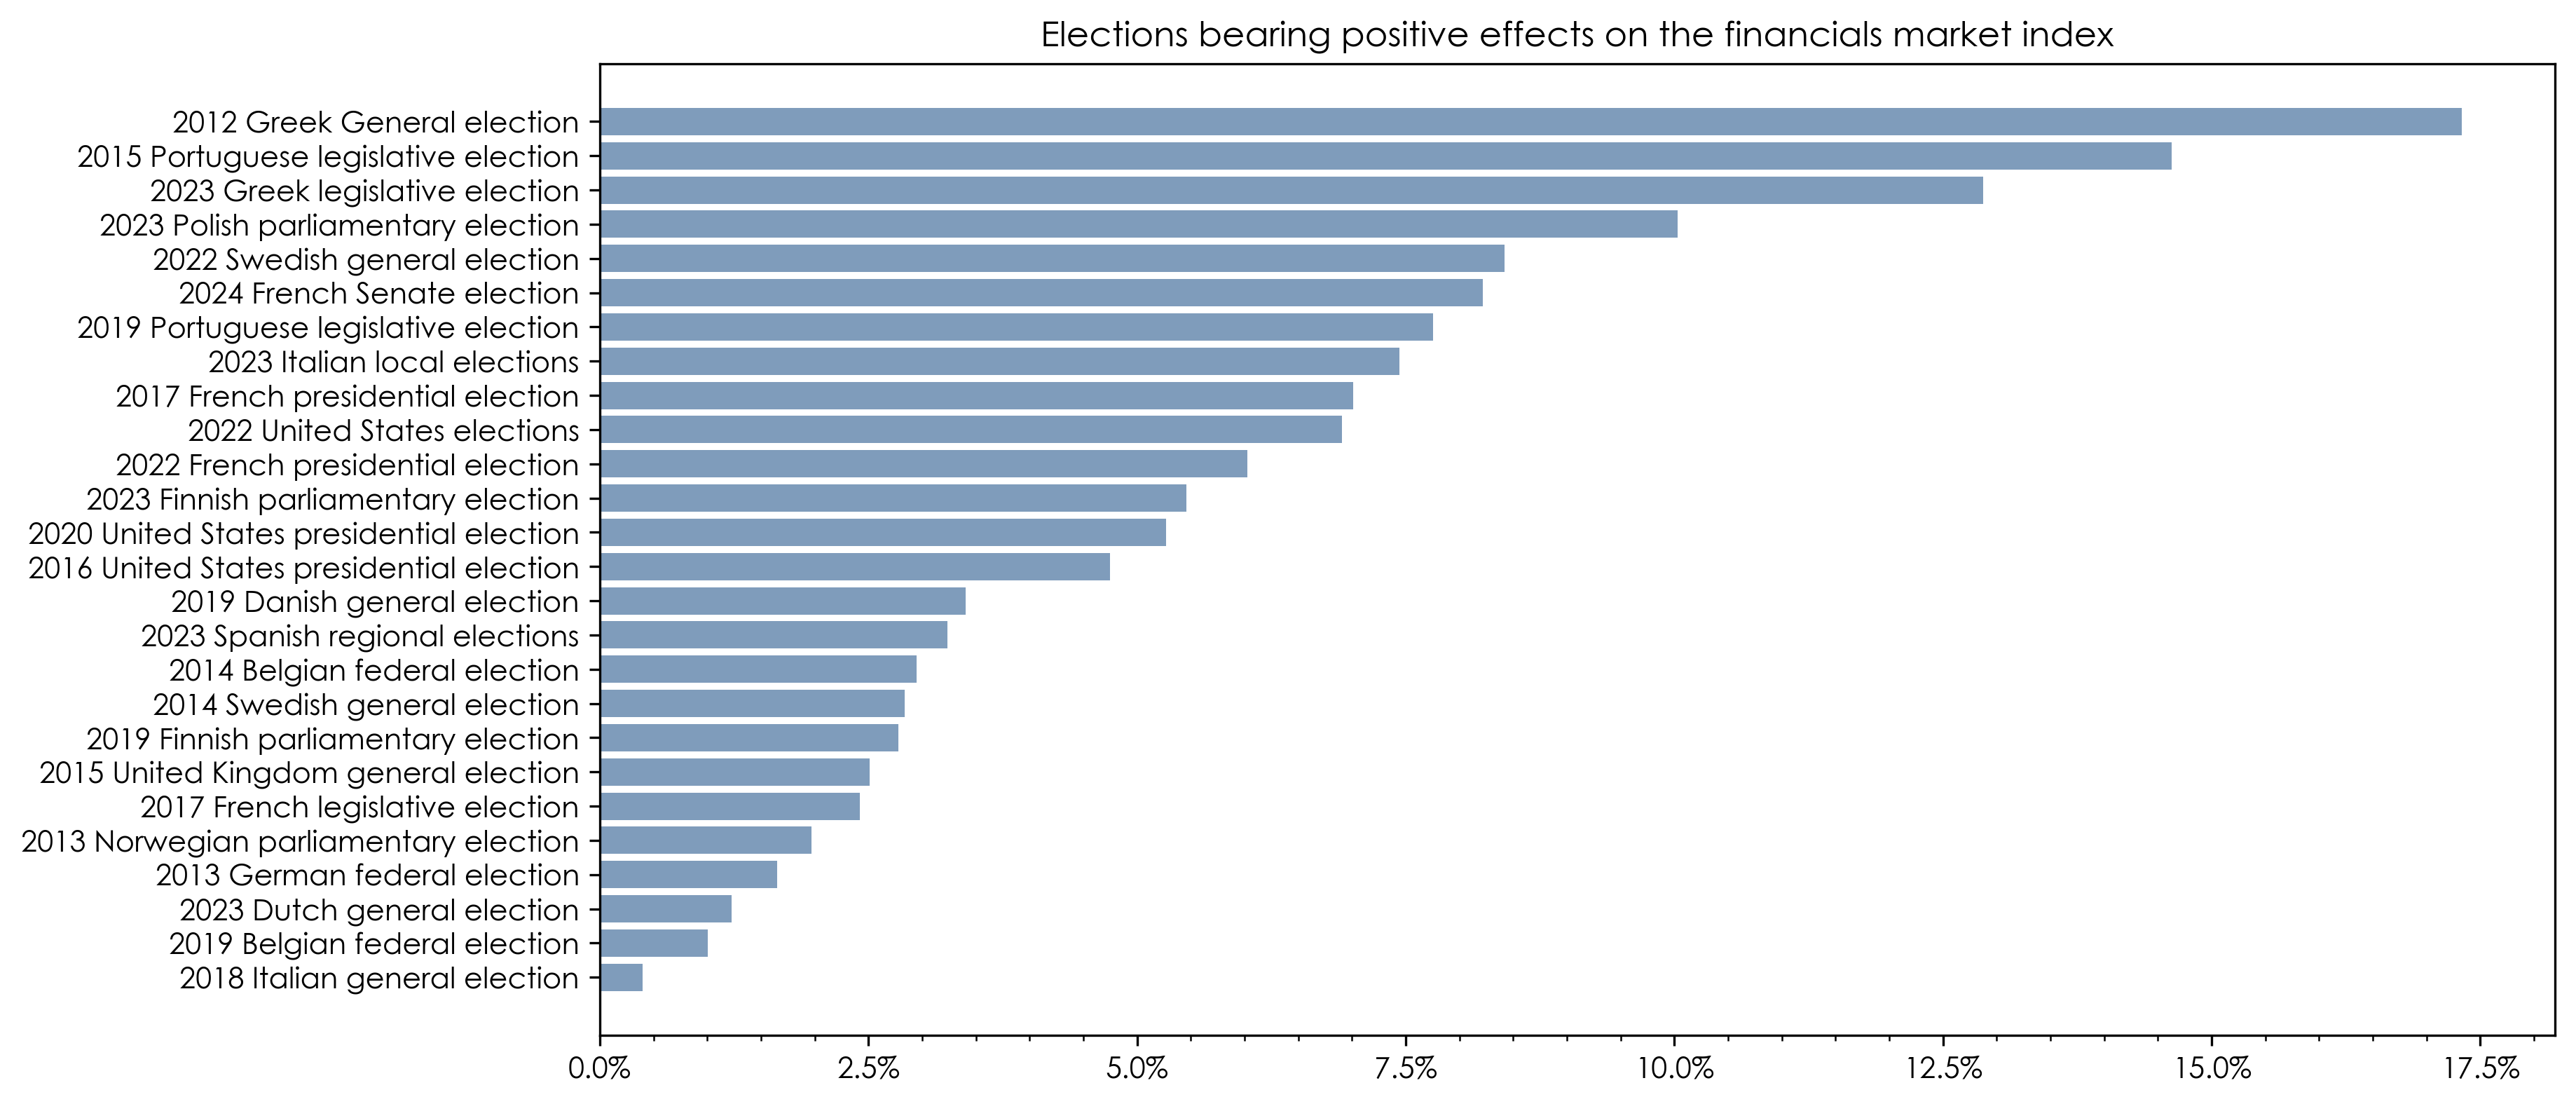

In [10]:
import matplotlib.pyplot as plt
from matplotlib import ticker
import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams['figure.dpi'] = 300

plt.rcParams["font.family"] = "Century Gothic"
fig, ax = plt.subplots()
fig.set_figheight(6)
fig.set_figwidth(12)


x = positive_effects.sort_values(by='Weighted_Significant_Mean', ascending=True).index

def label_creator(indexes):
    final_labels = []
    for text in indexes:
        words = ' '.join(text.split('_')[0:len(text.split('_'))-1])
        final_labels.append(words)
    return final_labels

# Assuming x is defined elsewhere


y1 = positive_effects.sort_values(by='Weighted_Significant_Mean', ascending=True)['Weighted_Significant_Mean']
x1 = positive_effects.sort_values(by='Weighted_Significant_Mean', ascending=True).index
y2 = negative_effects.sort_values(by='Weighted_Significant_Mean', ascending=True)['Weighted_Significant_Mean']
x2 = negative_effects.sort_values(by='Weighted_Significant_Mean', ascending=True).index

labels_pos = label_creator(x1)
label_neg = label_creator(x2)

ax.barh(labels_pos,y1, alpha = 0.5 , color=[(0,58/255,121/255)])


# ax.xaxis.set_major_locator(ticker.MultipleLocator(0.5))
ax.xaxis.set_major_formatter(ticker.PercentFormatter(xmax=100))
ax.xaxis.set_minor_locator(ticker.MultipleLocator(0.5))
# []ax.xaxis.set_major_locator(ticker.MultipleLocator(0.5))


plt.title("Elections bearing positive effects on the financials market index")
plt.show()




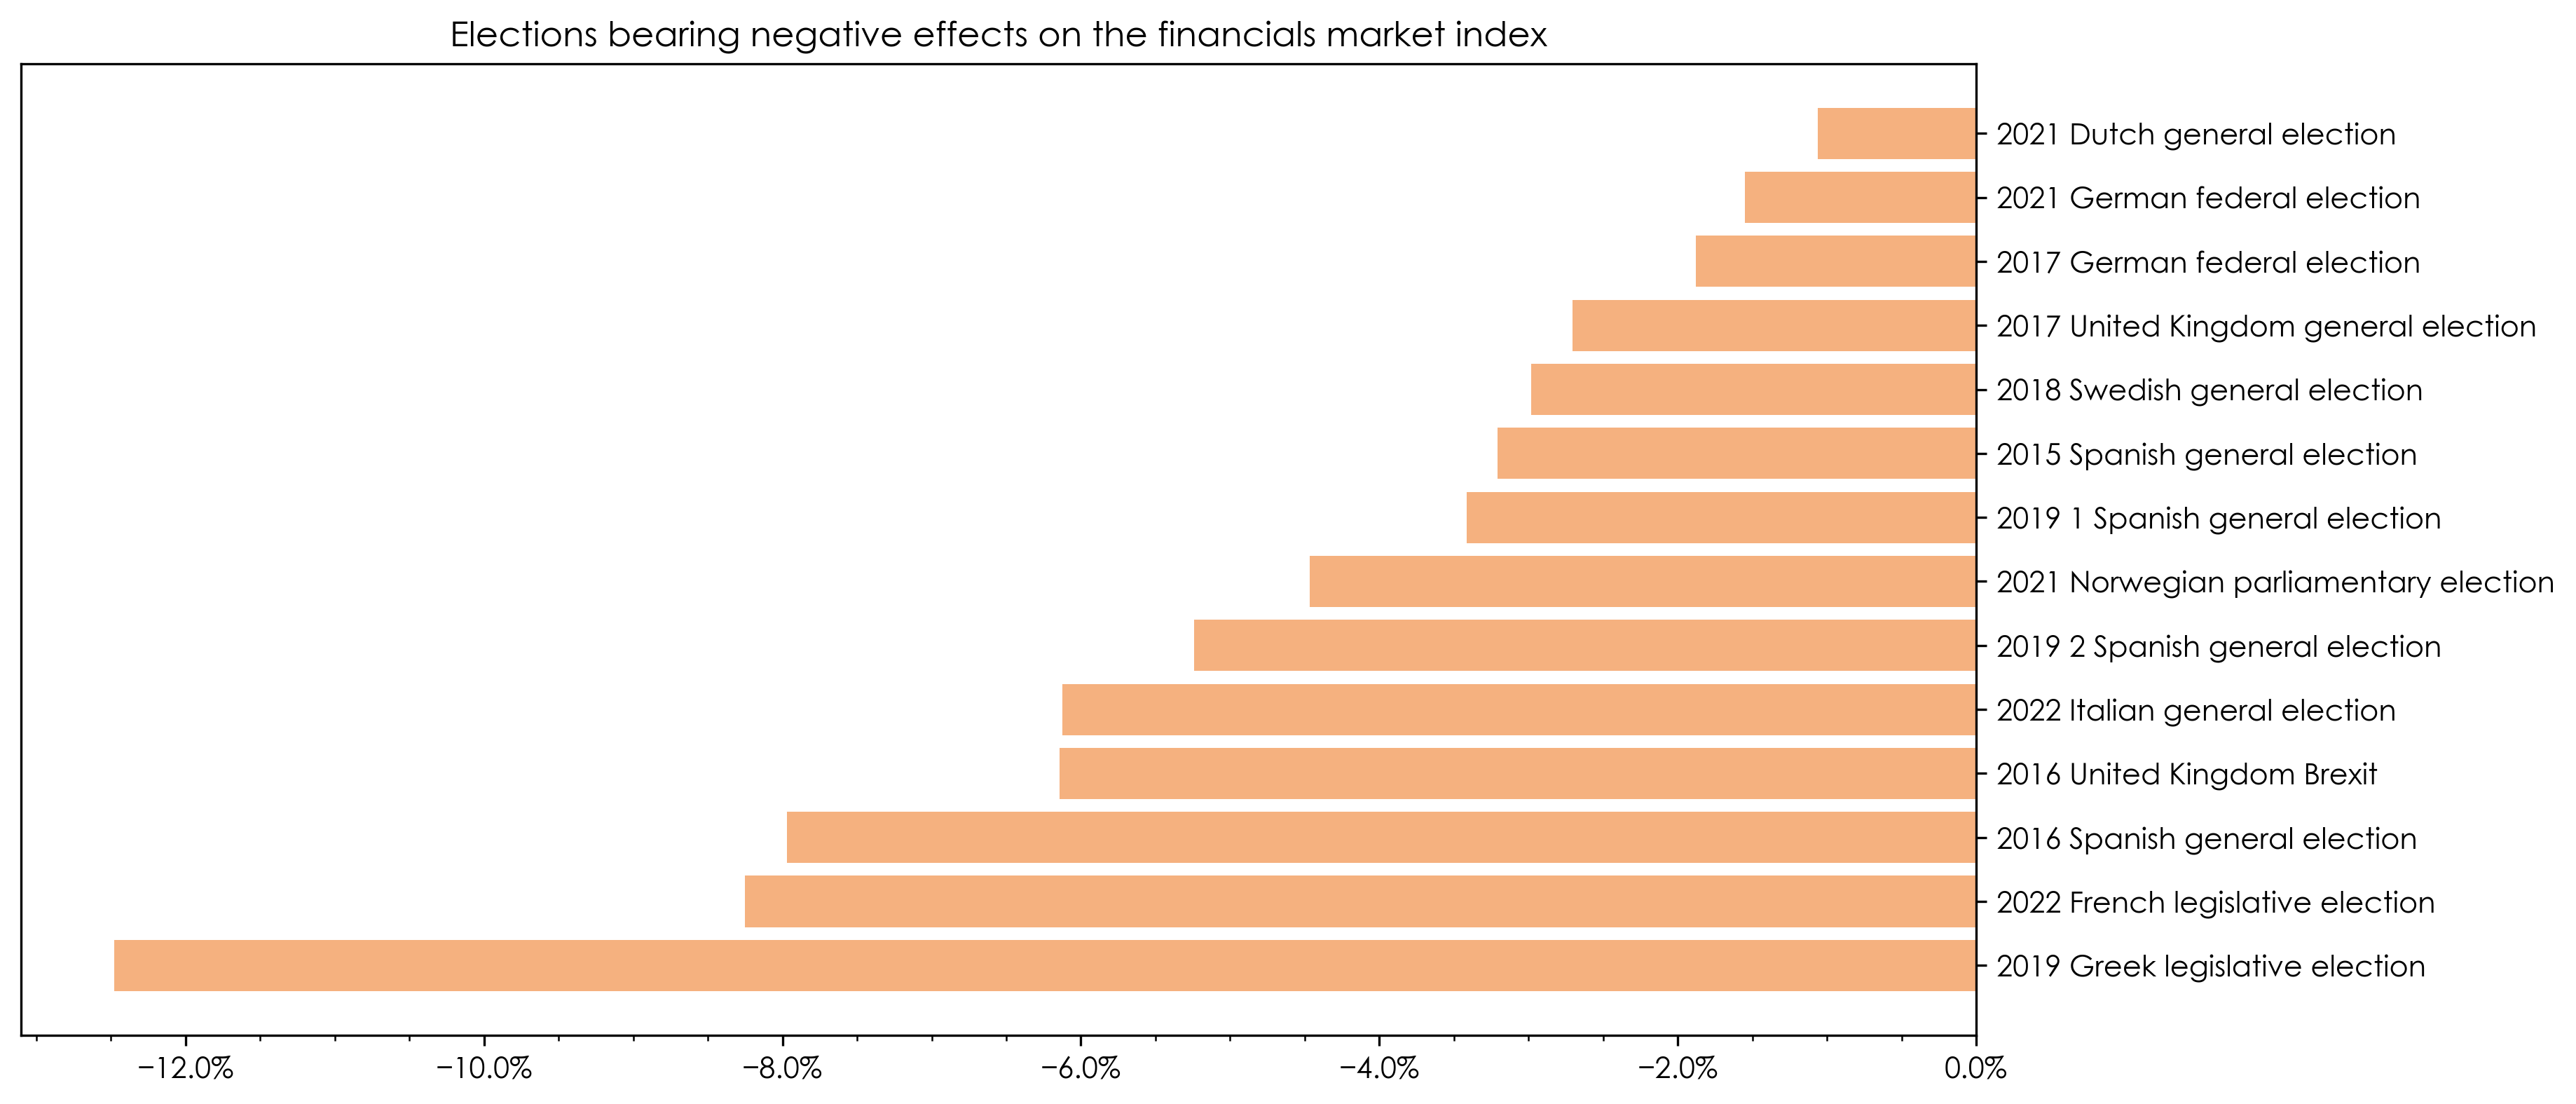

In [11]:
fig, ax = plt.subplots()
fig.set_figheight(6)
fig.set_figwidth(12)
ax.barh(label_neg,y2 , alpha = 0.5, color=[(236/255,100/256,0/255)])
ax.xaxis.set_major_formatter(ticker.PercentFormatter(xmax=100))
ax.xaxis.set_minor_locator(ticker.MultipleLocator(0.5))
ax.yaxis.set_label_position("right")
ax.yaxis.tick_right()
plt.title("Elections bearing negative effects on the financials market index")
plt.show()


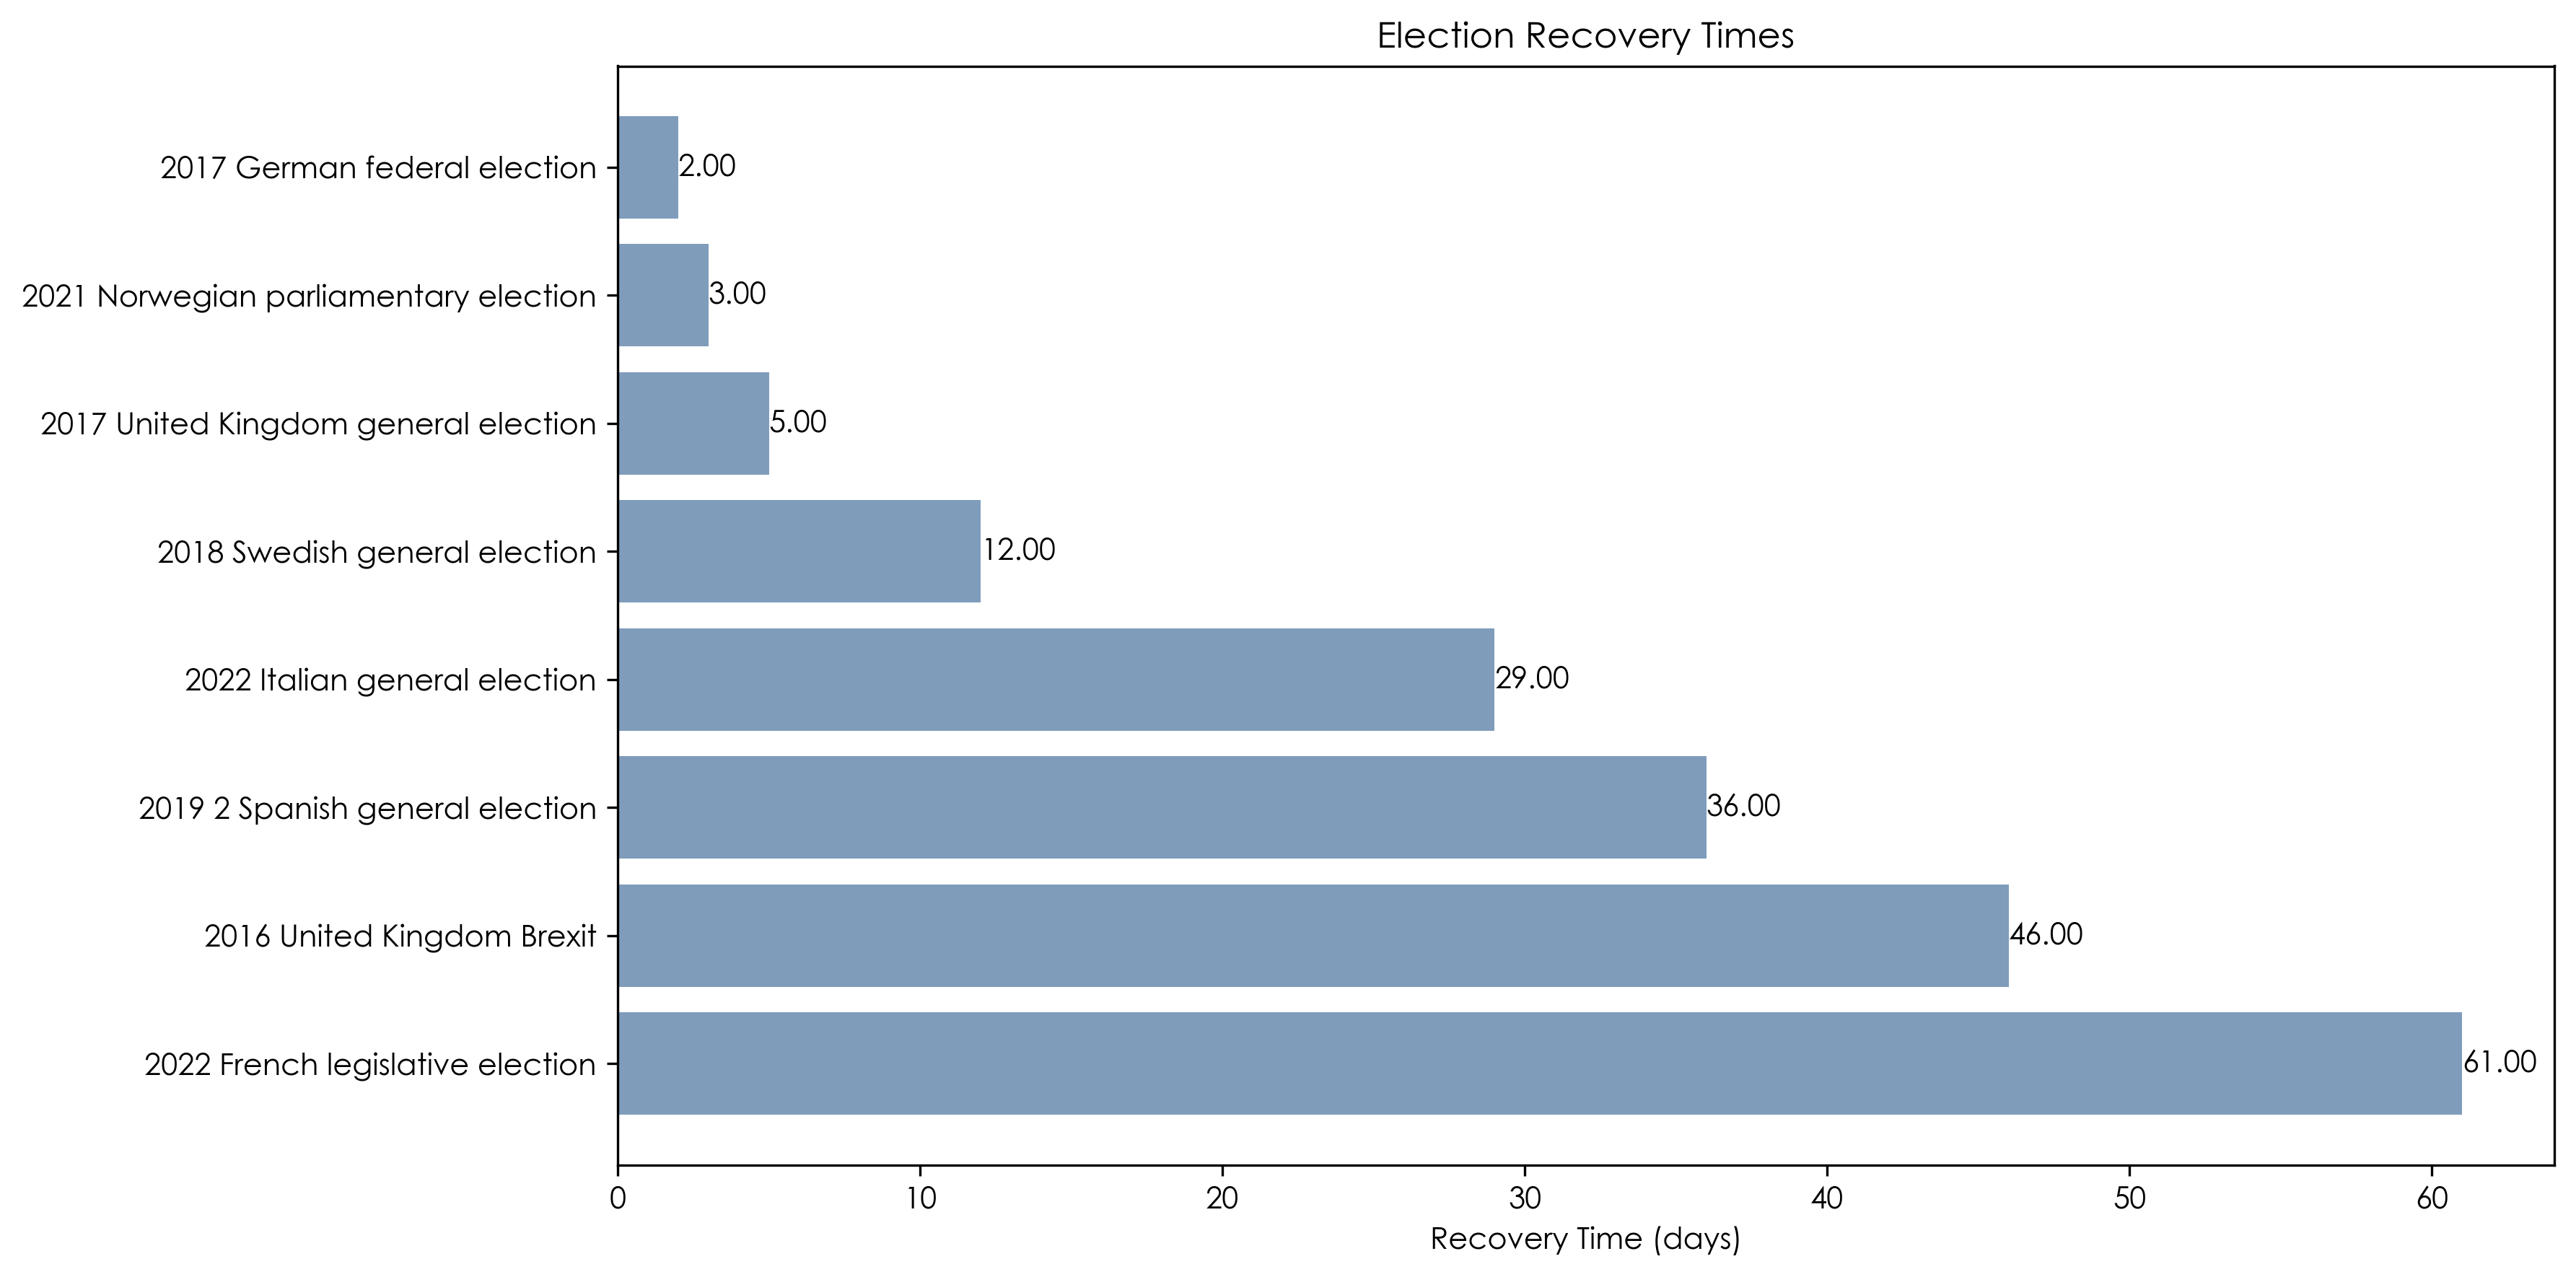

<Figure size 1920x1440 with 0 Axes>

In [12]:

def label_creator(indexes):
    final_labels = []
    for text in indexes:
        words = ' '.join(text.split('_')[0:len(text.split('_'))-1])
        final_labels.append(words)
    return final_labels

import matplotlib.pyplot as plt
import numpy as np

# Sort the recovery_times list by recovery time
sorted_recovery_times = sorted(recovery_times, key=lambda x: x[1])

# Separate the data into two lists

elections, times = zip(*sorted_recovery_times)
elections = label_creator(elections)

# Create the plot
fig, ax = plt.subplots(figsize=(12, 6))

# Create the horizontal bar plot
bars = ax.barh(elections, times, alpha = 0.5 , color=[(0,58/255,121/255)])

# Customize the plot
ax.set_xlabel('Recovery Time (days)')
ax.set_title('Election Recovery Times')
ax.invert_yaxis()  # Invert the y-axis to show the longest recovery time at the top

# Add value labels on the right side of each bar
for bar in bars:
    width = bar.get_width()
    ax.text(width, bar.get_y() + bar.get_height()/2, f'{width:.2f}',
            ha='left', va='center')

# Adjust layout and display the plot
plt.tight_layout()
plt.show()

# Save the plot as a PNG file
plt.savefig('election_recovery_times.png', dpi=300, bbox_inches='tight')

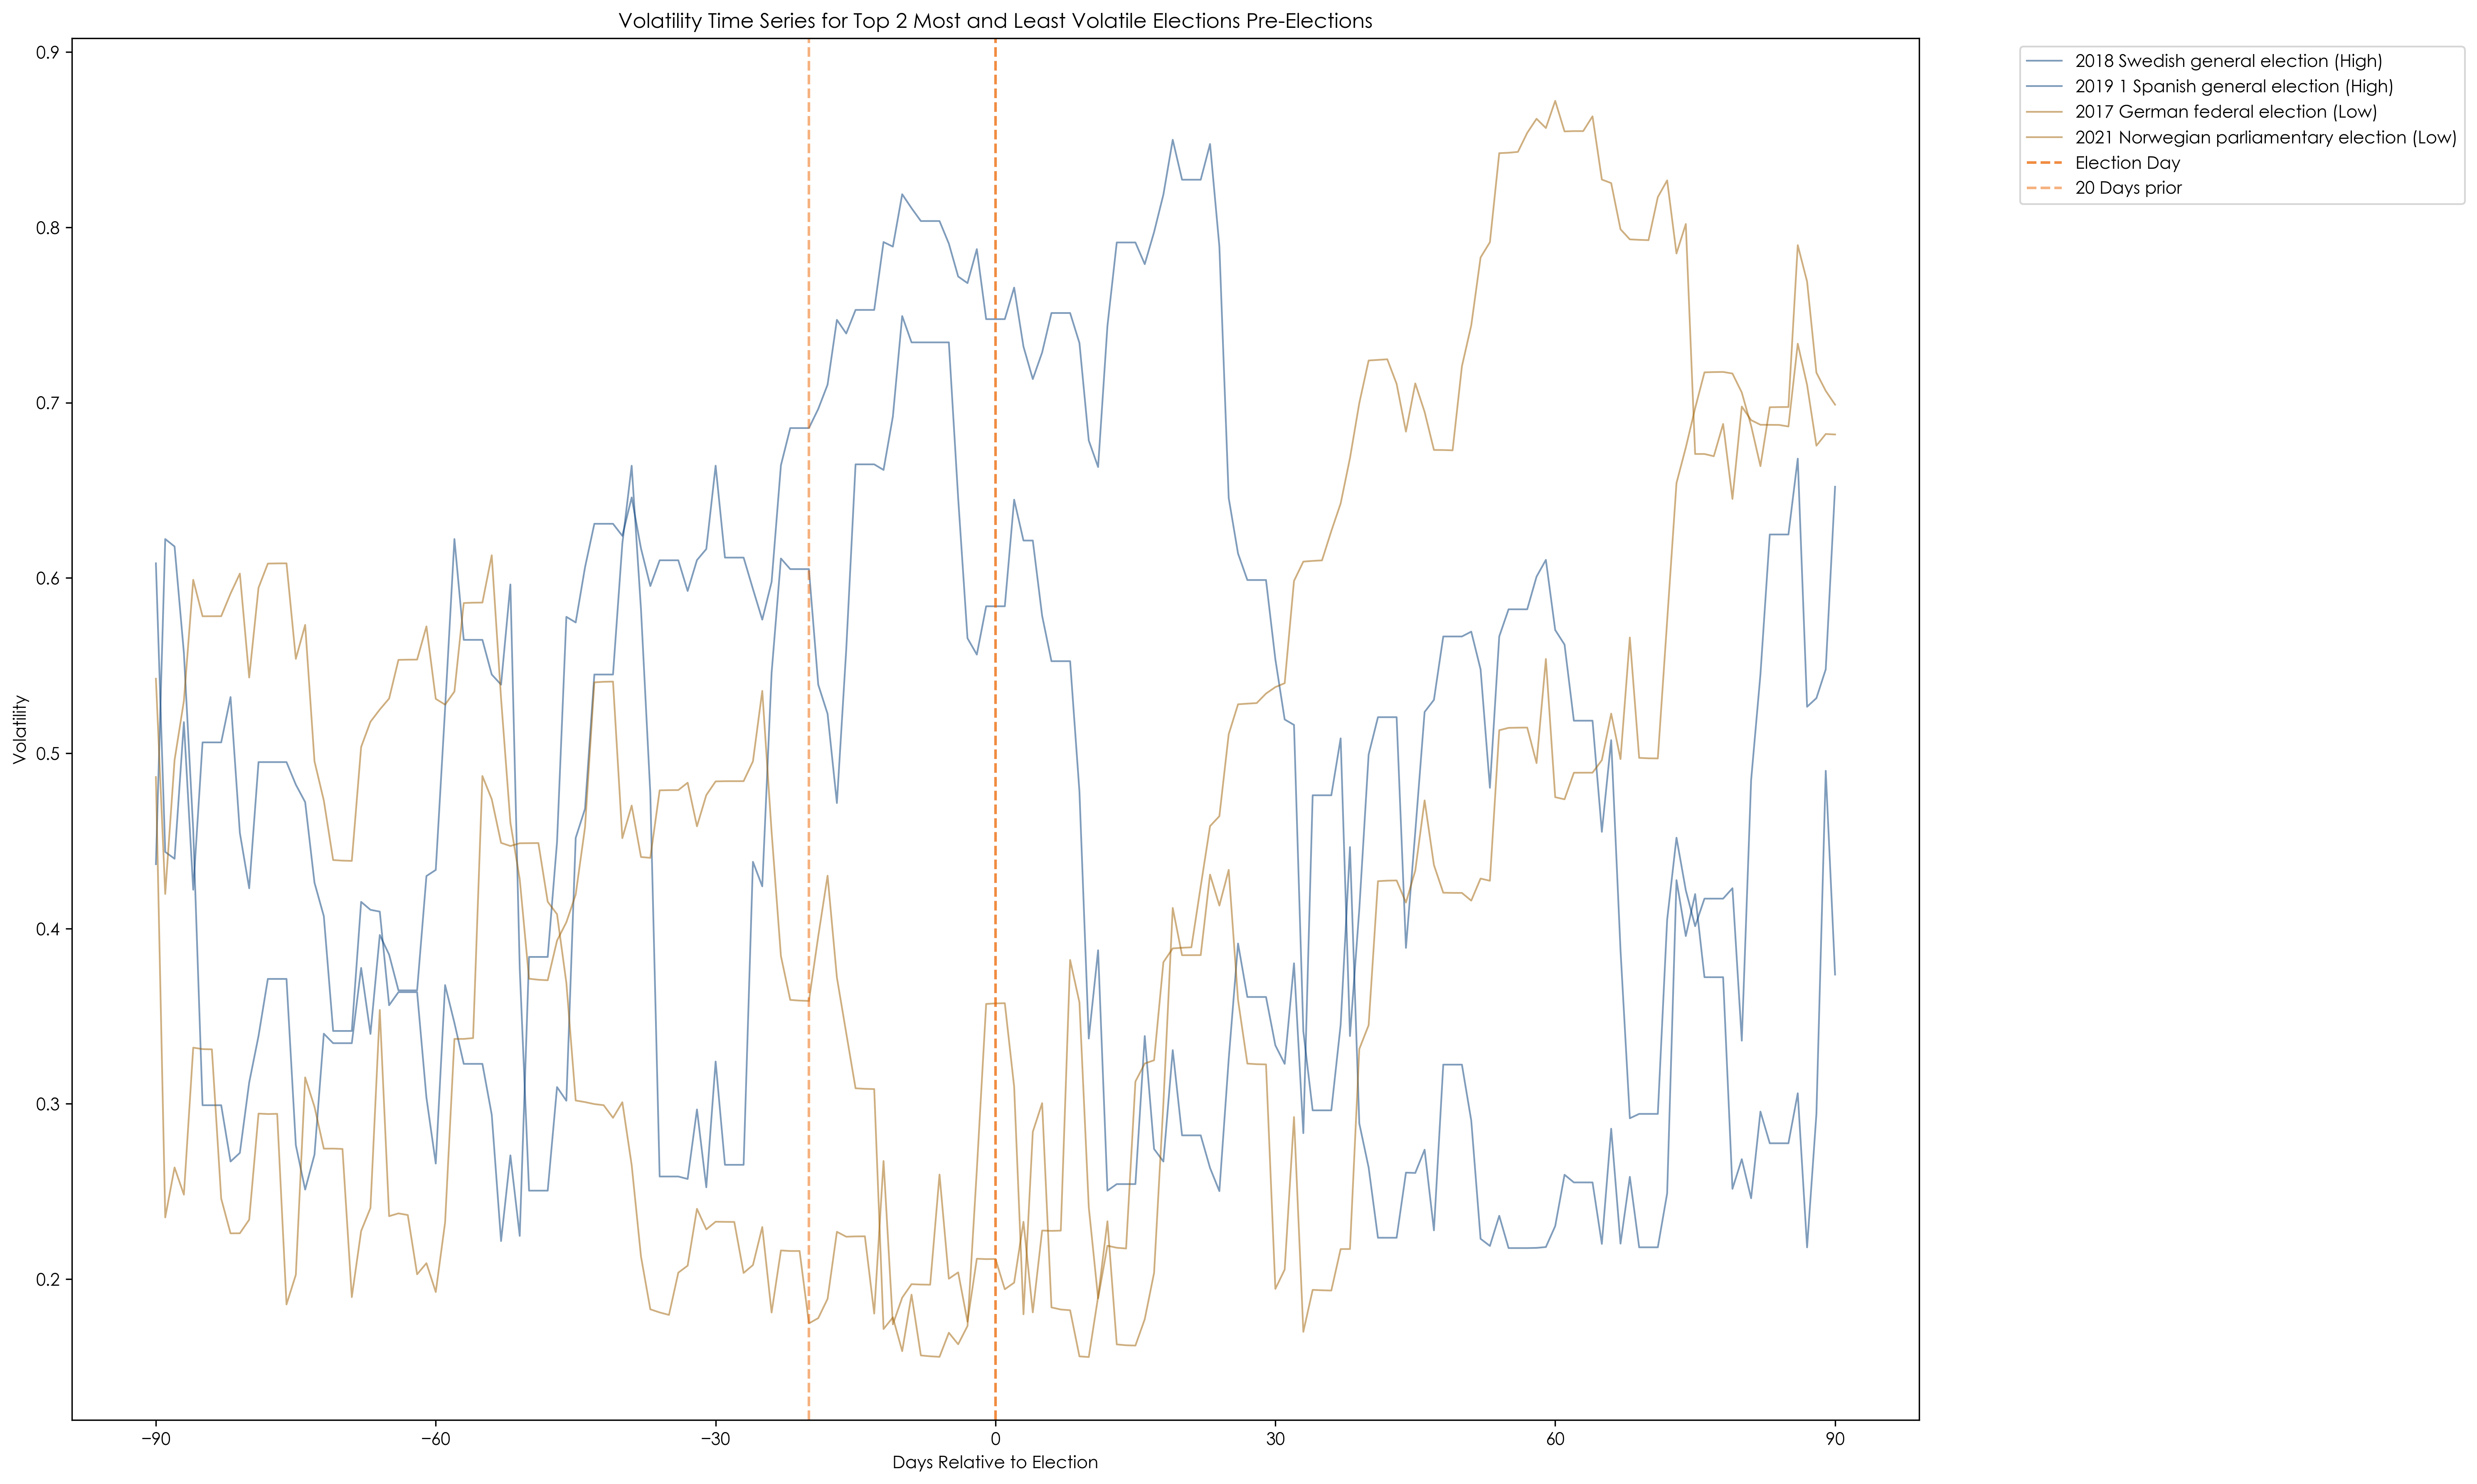

Top 3 Most Volatile Elections (Pre-Election Volatility):
2018_Swedish general election_SX3010GI: 0.790704
2019_1_Spanish general election_IBEXIB: 0.677259

Bottom 3 Least Volatile Elections (Pre-Election Volatility):
2017_German federal election_CXPVX: 0.194235
2021_Norwegian parliamentary election_OFING: 0.204210


<Figure size 1920x1440 with 0 Axes>

In [13]:
import matplotlib.pyplot as plt
import pandas as pd

def label_creator_reduced(sentence):
    return ' '.join(sentence.split('_')[0:len(sentence.split('_'))-1])

# Load the volatility data
volatilitydf = pd.read_csv('election_data_with_figarch_volatility_corrected.csv')
volatilitydf.set_index('NormalizedDate', inplace=True)

# Load the pre-election volatility data
volatility_data = pd.read_csv("pre_election_volatility.csv", index_col=0).squeeze("columns")

# Get the top 3 and bottom 3 elections with highest and lowest pre-election volatility
top_3_elections = volatility_data.nlargest(2)
bottom_3_elections = volatility_data.nsmallest(2)

# Create the plot
plt.figure(figsize=(20, 12))

# Plot top 3 (most volatile)
for election in top_3_elections.index:
    volatility_column = f"{election}_volatility"
    label_election = label_creator_reduced(election)
    plt.plot(volatilitydf.index, volatilitydf[volatility_column], label=f"{label_election} (High)", linewidth=1, color='#003A79', alpha=0.5)

# Plot bottom 3 (least volatile)
for election in bottom_3_elections.index:
    volatility_column = f"{election}_volatility"
    label_election = label_creator_reduced(election)
    plt.plot(volatilitydf.index, volatilitydf[volatility_column], label=f"{label_election} (Low)", linewidth=1,  color='#9f5f00', alpha=0.5)

plt.axvline(x=0, color='#EC6400', linestyle='--', label='Election Day', alpha = 0.75)
plt.axvline(x=-20, color='#EC6400', linestyle='--', label='20 Days prior', alpha=0.5 )
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.title("Volatility Time Series for Top 2 Most and Least Volatile Elections Pre-Elections")
plt.xlabel("Days Relative to Election")
plt.ylabel("Volatility")

# Adjust x-axis to show more tick marks
plt.xticks(range(-90, 91, 30))

plt.tight_layout()
plt.show()

# Save the plot
plt.savefig('top_and_bottom_3_elections_volatility.png', dpi=300, bbox_inches='tight')

# Print the top 3 and bottom 3 elections and their pre-election volatility
print("Top 3 Most Volatile Elections (Pre-Election Volatility):")
for election, volatility in top_3_elections.items():
    print(f"{election}: {volatility:.6f}")

print("\nBottom 3 Least Volatile Elections (Pre-Election Volatility):")
for election, volatility in bottom_3_elections.items():
    print(f"{election}: {volatility:.6f}")

In [14]:
def average(input):
    return np.average(input)

linear_weighted_avg_r2 = average(results_df['Linear_R2'])
non_linear_2nd_weighted_avg_r2 = average(results_df['NonLinear_2nd_R2'])
non_linear_3rd_weighted_avg_r2 = average(results_df['NonLinear_3rd_R2'])
non_linear_4th_weighted_avg_r2 = average(results_df['NonLinear_4th_R2'])
overall_mean_effect_r2 = np.mean([linear_weighted_avg_r2, non_linear_2nd_weighted_avg_r2, non_linear_3rd_weighted_avg_r2,non_linear_4th_weighted_avg_r2])
overall_mean_effect_r2


0.7997822270076861

# Model on Market direction

In [15]:

# Function to normalize dates relative to an election date
import pandas as pd
import os
from datetime import datetime, timedelta
import numpy as np

# Load the elections data
elections_df = pd.read_csv('DATA/Initial Data.csv')
# Main processing
all_dfs = []
csv_directory = 'DATA/INDICES/'
output_directory = 'DATA/OUTPUT/'

def normalize_dates(df, election_date):
    df['NormalizedDate'] = (df['Date'] - election_date).dt.days
    return df[(df['NormalizedDate'] >= -90) & (df['NormalizedDate'] <= 90)].copy()

# Function to clean price data
def clean_price(price):
    if isinstance(price, str):
        return float(price.replace(',', ''))
    return float(price)

# Function to perform min-max normalization
def min_max_normalize(series):
    min_val = series.min()
    max_val = series.max()
    return (series - min_val) / (max_val - min_val)

# Function to load and process index data
def process_index(file_path, election_date, index_name, election_name):
    df = pd.read_csv(file_path)
    df['Date'] = pd.to_datetime(df['Date'])
    df['Price'] = df['Price'].apply(clean_price)
    df = df.sort_values('Date')
    
    normalized_df = normalize_dates(df, election_date)
    if not normalized_df.empty:
        # Apply min-max normalization to the Price column
        normalized_df.loc[:, 'Price'] = min_max_normalize(normalized_df['Price'])
        column_name = f"{election_name}_{index_name}"
        return normalized_df[['NormalizedDate', 'Price']].rename(columns={'Price': column_name})
    return None


for _, election in elections_df.iterrows():
    index_name = election['Index']
    election_date = pd.to_datetime(election['Date 1'])
    election_name = f"{election['Year']}_{election['Elections']}"
    filep = csv_directory + index_name + ".csv"
    file_path = os.path.abspath(filep)
    print(file_path)
    if os.path.exists(file_path):
        processed_df = process_index(file_path, election_date, index_name, election_name)
        if processed_df is not None:
            all_dfs.append(processed_df)
    else:
        print(f"Warning: File not found for index {index_name}")

if all_dfs:
    merged_df = all_dfs[0]
    for df in all_dfs[1:]:
        merged_df = pd.merge(merged_df, df, on='NormalizedDate', how='outer')
    
    # Sort by NormalizedDate
    merged_df = merged_df.sort_values('NormalizedDate')
    
    # Fill NaN values using forward fill and then backward fill
    merged_df = merged_df.ffill().bfill()
    
    # Save the final dataframe to a CSV file
    merged_df.to_csv('data_merged_log_for_volatility.csv', index=False)
    print("Processing complete. Data saved to 'log_norm_election_data.csv'")
else:
    print("No data processed. Check your input files and paths.")

c:\Users\apuza\iCloudDrive\Intesa\Political Risk\UPDATE\DATA\INDICES\FRFIN.csv
c:\Users\apuza\iCloudDrive\Intesa\Political Risk\UPDATE\DATA\INDICES\IBEXIB.csv
c:\Users\apuza\iCloudDrive\Intesa\Political Risk\UPDATE\DATA\INDICES\NLFIN.csv
c:\Users\apuza\iCloudDrive\Intesa\Political Risk\UPDATE\DATA\INDICES\BNKI.csv
c:\Users\apuza\iCloudDrive\Intesa\Political Risk\UPDATE\DATA\INDICES\FTATBNK.csv
c:\Users\apuza\iCloudDrive\Intesa\Political Risk\UPDATE\DATA\INDICES\N3020PI.csv
c:\Users\apuza\iCloudDrive\Intesa\Political Risk\UPDATE\DATA\INDICES\FTITLMS30.csv
c:\Users\apuza\iCloudDrive\Intesa\Political Risk\UPDATE\DATA\INDICES\IBEXIB.csv
c:\Users\apuza\iCloudDrive\Intesa\Political Risk\UPDATE\DATA\INDICES\NYK.csv
c:\Users\apuza\iCloudDrive\Intesa\Political Risk\UPDATE\DATA\INDICES\FRFIN.csv
c:\Users\apuza\iCloudDrive\Intesa\Political Risk\UPDATE\DATA\INDICES\FRFIN.csv
c:\Users\apuza\iCloudDrive\Intesa\Political Risk\UPDATE\DATA\INDICES\SX3010GI.csv
c:\Users\apuza\iCloudDrive\Intesa\Politica

In [16]:
df = pd.read_csv('data_merged_log_for_volatility.csv')
df.head(10)

NormalizedDate  2024_French Senate election_FRFIN  \
0             -90                           0.624410   
1             -89                           0.624410   
2             -88                           0.694300   
3             -87                           0.720864   
4             -86                           0.648614   
5             -85                           0.648614   
6             -84                           0.648614   
7             -83                           0.683589   
8             -82                           0.636815   
9             -81                           0.643592   

   2023_Spanish general election_IBEXIB  2023_Dutch general election_NLFIN  \
0                              0.611159                           0.463934   
1                              0.415451                           0.459766   
2                              0.390558                           0.459766   
3                              0.461803                           0.459766   
4                              0.263519                           0.533403   
5                              0.263519                           0.609934   
6                              0.263519                           0.600787   
7                              0.263519                           0.511173   
8                              0.117597                           0.508510   
9                              0.084979                           0.508510   

   2023_Polish parliamentary election_BNKI  \
0                                 0.292275   
1                                 0.341135   
2                                 0.338960   
3                                 0.328246   
4                                 0.311087   
5                                 0.311087   
6                                 0.311087   
7                                 0.328603   
8                                 0.323458   
9                                 0.316516   

   2023_Greek legislative election_FTATBNK  \
0                                 0.468834   
1                                 0.490797   
2                                 0.387747   
3                                 0.446255   
4                                 0.443044   
5                                 0.443044   
6                                 0.443044   
7                                 0.443044   
8                                 0.518646   
9                                 0.527020   

   2023_Finnish parliamentary election_N3020PI  \
0                                     0.237293   
1                                     0.291693   
2                                     0.364160   
3                                     0.339128   
4                                     0.339128   
5                                     0.339128   
6                                     0.339128   
7                                     0.498294   
8                                     0.458788   
9                                     0.589409   

   2023_Italian local elections_FTITLMS30  \
0                                0.221150   
1                                0.221150   
2                                0.221150   
3                                0.189968   
4                                0.181956   
5                                0.127439   
6                                0.171152   
7                                0.171152   
8                                0.171152   
9                                0.232447   

   2023_Spanish regional elections_IBEXIB  2022_United States elections_NYK  \
0                                0.736179                          0.781360   
1                                0.878936                          0.807486   
2                                0.819454                          0.878617   
3                                0.820854                          0.878617   
4                                0.934220                          0.87

In [17]:
import pandas as pd
import numpy as np
from arch import arch_model
import warnings
warnings.filterwarnings('ignore')

# Load the data
data = pd.read_csv('data_merged_log_for_volatility.csv')
data.set_index('NormalizedDate', inplace=True)

def fit_figarch_and_get_volatility(series):
    # Remove NaN values
    series = series.dropna()
    
    # Reverse the series for FIGARCH modeling
    
    # Fit FIGARCH(1,d,1) model
    model = arch_model(series, vol='FIGARCH', p=1, o=0 ,q=0)
    
    try:
        results = model.fit(disp='off')
        # Extract conditional volatility
        volatility = np.sqrt(results.conditional_volatility)
        # Reverse the volatility series back to original order
        return pd.Series(volatility, index=series.index)
    except:
        print(f"Failed to fit EGARCH model for {series.name}")
        return pd.Series(index=series.index)

# Apply FIGARCH to each election time series and store results
volatilitydf = pd.DataFrame()
for column in data.columns:
    if column != 'NormalizedDate':
        volatility_column = f"{column}_volatility"
        volatilitydf[volatility_column] = fit_figarch_and_get_volatility(data[column])

# Save the results
volatilitydf.to_csv('election_data_with_figarch_volatility_corrected.csv')
print("Corrected FIGARCH volatility analysis complete. Results saved to 'election_data_with_figarch_volatility_corrected.csv'")

Corrected FIGARCH volatility analysis complete. Results saved to 'election_data_with_figarch_volatility_corrected.csv'


In [18]:
volatilitydf.count()

2024_French Senate election_FRFIN_volatility                    181
2023_Spanish general election_IBEXIB_volatility                 181
2023_Dutch general election_NLFIN_volatility                    181
2023_Polish parliamentary election_BNKI_volatility              181
2023_Greek legislative election_FTATBNK_volatility              181
2023_Finnish parliamentary election_N3020PI_volatility          181
2023_Italian local elections_FTITLMS30_volatility               181
2023_Spanish regional elections_IBEXIB_volatility               181
2022_United States elections_NYK_volatility                     181
2022_French presidential election_FRFIN_volatility              181
2022_French legislative election_FRFIN_volatility               181
2022_Swedish general election_SX3010GI_volatility               181
2022_Italian general election_FTITLMS30_volatility              181
2021_German federal election_CXPVX_volatility                   181
2021_Norwegian parliamentary election_OFING_vola

In [19]:
import pandas as pd
import numpy as np
from arch import arch_model
import warnings
warnings.filterwarnings('ignore')

# Load the data
volatilitydf = pd.read_csv('election_data_with_figarch_volatility_corrected.csv')
volatilitydf.set_index('NormalizedDate', inplace=True)

# Function to calculate average volatility for 10 days prior to election
def calculate_pre_election_volatility(df):
    volatility_data = {}
    
    for column in df.columns:
        if column.endswith('_volatility'):
            # Extract the election name (remove '_volatility' suffix)
            election_name = column[:-11]
            
            # Select data for 10 days prior to election (-10 to -1)
            pre_election_data = df.loc[-10:-1, column]
            
            # Calculate average volatility
            avg_volatility = pre_election_data.mean()
            
            volatility_data[election_name] = avg_volatility
    
    return pd.Series(volatility_data)

# Calculate pre-election volatility for each election
volatility_data = calculate_pre_election_volatility(volatilitydf)

# Display results
print("Average volatility for 10 days prior to each election:")
print(volatility_data)
volatility_data.to_csv("pre_election_volatility.csv")


Average volatility for 10 days prior to each election:
2024_French Senate election_FRFIN                    0.512058
2023_Spanish general election_IBEXIB                 0.234906
2023_Dutch general election_NLFIN                    0.332226
2023_Polish parliamentary election_BNKI              0.371044
2023_Greek legislative election_FTATBNK              0.381714
2023_Finnish parliamentary election_N3020PI          0.515154
2023_Italian local elections_FTITLMS30               0.401169
2023_Spanish regional elections_IBEXIB               0.402192
2022_United States elections_NYK                     0.375588
2022_French presidential election_FRFIN              0.307196
2022_French legislative election_FRFIN               0.224463
2022_Swedish general election_SX3010GI               0.316888
2022_Italian general election_FTITLMS30              0.382577
2021_German federal election_CXPVX                   0.246233
2021_Norwegian parliamentary election_OFING          0.204210
2021_Dutch gene

In [20]:
binary_effect_data = pd.DataFrame(index=results_df.index)
results_df['Mean_Effect'] = results_df[['Linear_Intervention', 'NonLinear_2nd_Intervention', 'NonLinear_3rd_Intervention','NonLinear_4th_Intervention']].mean(axis=1)
binary_effect_data['Effect'] = (results_df['Mean_Effect'] < 0).astype(int)
print("\nBinary Classification of Election Effects:")
print(binary_effect_data)
binary_effect_data.to_csv('election_effect_classification.csv')

print("\nBinary classification dataset saved as 'election_effect_classification.csv'")


Binary Classification of Election Effects:
                                                   Effect
2024_French Senate election_FRFIN                       0
2023_Spanish general election_IBEXIB                    0
2023_Dutch general election_NLFIN                       0
2023_Polish parliamentary election_BNKI                 0
2023_Greek legislative election_FTATBNK                 0
2023_Finnish parliamentary election_N3020PI             0
2023_Italian local elections_FTITLMS30                  0
2023_Spanish regional elections_IBEXIB                  0
2022_United States elections_NYK                        0
2022_French presidential election_FRFIN                 0
2022_French legislative election_FRFIN                  1
2022_Swedish general election_SX3010GI                  0
2022_Italian general election_FTITLMS30                 1
2021_German federal election_CXPVX                      1
2021_Norwegian parliamentary election_OFING             1
2021_Dutch general election_

In [21]:
def analyze_election_prices(data):
    # Convert the 'NormalizedDate' column to integer
    data['NormalizedDate'] = data['NormalizedDate'].astype(int)

    # Initialize a dictionary to store results
    results = {}

    # Iterate through all columns except 'NormalizedDate'
    for column in data.columns[1:]:
        # Filter data for the range [-90, -1]
        pre_election_data = data[(data['NormalizedDate'] >= -90) & (data['NormalizedDate'] <= -10)][['NormalizedDate', column]]
        
        # Calculate the median for the range [-90, -1]
        median_90_to_1 = pre_election_data[column].median()
        
        # Calculate the average for the range [-10, -1]
        avg_10_to_1 = pre_election_data[
            (pre_election_data['NormalizedDate'] >= -10) & 
            (pre_election_data['NormalizedDate'] <= -1)
        ][column].mean()
        
        # Calculate the spread
        spread = avg_10_to_1 - median_90_to_1
        
        # Store the result
        results[column] = spread

    # Create a DataFrame from the results
    result_df = pd.DataFrame.from_dict(results, orient='index', columns=['Spread'])
    return result_df

# Load the data
result_df = pd.read_csv('data_merged_log_for_volatility.csv')

# Run the analysis
spread_data = analyze_election_prices(result_df)


spread_data.to_csv('election_price_spread_analysis.csv')



# Display the results
print(spread_data.count)

<bound method DataFrame.count of                                                      Spread
2024_French Senate election_FRFIN                 -0.492860
2023_Spanish general election_IBEXIB               0.431760
2023_Dutch general election_NLFIN                 -0.099340
2023_Polish parliamentary election_BNKI           -0.103777
2023_Greek legislative election_FTATBNK            0.141894
2023_Finnish parliamentary election_N3020PI       -0.445299
2023_Italian local elections_FTITLMS30            -0.222711
2023_Spanish regional elections_IBEXIB            -0.188244
2022_United States elections_NYK                   0.009682
2022_French presidential election_FRFIN           -0.278028
2022_French legislative election_FRFIN            -0.062578
2022_Swedish general election_SX3010GI            -0.087335
2022_Italian general election_FTITLMS30            0.233679
2021_German federal election_CXPVX                -0.219033
2021_Norwegian parliamentary election_OFING        0.060660
2021_Du

In [22]:

# Load the data
spread_data = pd.read_csv('election_price_spread_analysis.csv', index_col=0)
volatility_data = pd.read_csv('pre_election_volatility.csv', index_col=0)
binary_effect_data = pd.read_csv('election_effect_classification.csv', index_col=0)



In [23]:
binary_effect_data

Effect
2024_French Senate election_FRFIN                       0
2023_Spanish general election_IBEXIB                    0
2023_Dutch general election_NLFIN                       0
2023_Polish parliamentary election_BNKI                 0
2023_Greek legislative election_FTATBNK                 0
2023_Finnish parliamentary election_N3020PI             0
2023_Italian local elections_FTITLMS30                  0
2023_Spanish regional elections_IBEXIB                  0
2022_United States elections_NYK                        0
2022_French presidential election_FRFIN                 0
2022_French legislative election_FRFIN                  1
2022_Swedish general election_SX3010GI                  0
2022_Italian general election_FTITLMS30                 1
2021_German federal election_CXPVX                      1
2021_Norwegian parliamentary election_OFING             1
2021_Dutch general election_NLFIN                       1
2020_United States presidential election_NYK            0
2019_1_Spanish general election_IBEXIB                  1
2019_2_Spanish general election_IBEXIB                  1
2019_Portuguese legislative election_PTFIN              0
2019_Greek legislative election_FTATBNK                 1
2019_Belgian federal election_BEFIN                     0
2019_Danish general election_OMXC20                     0
2019_Finnish parliamentary election_N3020PI             0
2018_Swedish general election_SX3010GI                  1
2018_Italian general election_FTITLMS30                 1
2017_German federal election_CXPVX                      1
2017_French presidential election_FRFIN                 0
2017_French legislative election_FRFIN                  0
2017_United Kingdom general election_TRINMX302020       1
2017_Dutch general election_NLFIN                       1
2016_United States presidential election_NYK            0
2016_Spanish general election_IBEXIB                    1
2016_United Kingdom Brexit_TRINMX302020                 1
2015_Portuguese legislative election_PTFIN              0
2015_Spanish general election_IBEXIB                    1
2015_United Kingdom general election_TRINMX302020       0
2014_Swedish general election_SX3010GI                  0
2014_Belgian federal election_BEFIN                     0
2013_German federal election_CXPVX                      0
2013_Norwegian parliamentary election_OFING             0
2012_Greek General election_FTATBNK                     0

## Forecasting the effect of the direction of the election using Volatility and Price

In [24]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.preprocessing import StandardScaler

# Load the data
spread_data = pd.read_csv('election_price_spread_analysis.csv', index_col=0)
volatility_data = pd.read_csv('pre_election_volatility.csv', index_col=0)
binary_effect_data = pd.read_csv('election_effect_classification.csv', index_col=0)

# Reset index for volatility_data to match the other datasets
volatility_data = volatility_data.reset_index()
volatility_data.index = spread_data.index
volatility_data = volatility_data.drop(columns=['index'])

# Combine spread and volatility
X = pd.merge(spread_data, volatility_data, left_index=True, right_index=True, how='inner')

# Ensure all datasets have the same index
common_index = X.index.intersection(binary_effect_data.index)
X = X.loc[common_index]
y = binary_effect_data.loc[common_index, 'Effect']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Scale the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

def calculate_class_weight(y):
    unique_classes, class_counts = np.unique(y, return_counts=True)
    total_samples = len(y)
    class_weights = {}
    
    for class_label, class_count in zip(unique_classes, class_counts):
        class_weight = total_samples / (2.0*class_count)
        class_weights[class_label] = class_weight
        
    return class_weights

class_weights = calculate_class_weight(y_train)

# Create and train the logistic regression model
model = LogisticRegression(random_state=42, class_weight=class_weights, solver='liblinear', verbose=0 )
model.fit(X_train_scaled, y_train)

# Make predictions on the test set
y_pred_1 = model.predict(X_test_scaled)
y_pred_2 = model.predict(X_train_scaled)

# Evaluate the model
print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred_1))
print("\nClassification Report:")
print(classification_report(y_test, y_pred_1))

# Print model coefficients
print("\nModel Coefficients:")
for feature, coef in zip(X.columns, model.coef_[0]):
    print(f"{feature}: {coef}")

# Print model intercept
print(f"\nIntercept: {model.intercept_[0]}")

# Calculate and print odds ratios
print("\nOdds Ratios:")
odds_ratios = np.exp(model.coef_[0])
for feature, odds_ratio in zip(X.columns, odds_ratios):
    print(f"{feature}: {odds_ratio}")
    
# Evaluate the model
print("\nConfusion Matrix:")
print(confusion_matrix(y_train, y_pred_2))
print("\nClassification Report:")
print(classification_report(y_train, y_pred_2))

# Print model coefficients
print("\nModel Coefficients:")
for feature, coef in zip(X.columns, model.coef_[0]):
    print(f"{feature}: {coef}")

# Print model intercept
print(f"\nIntercept: {model.intercept_[0]}")

# Calculate and print odds ratios
print("\nOdds Ratios:")
odds_ratios = np.exp(model.coef_[0])
for feature, odds_ratio in zip(X.columns, odds_ratios):
    print(f"{feature}: {odds_ratio}")
    


Confusion Matrix:
[[4 2]
 [2 5]]

Classification Report:
              precision    recall  f1-score   support

           0       0.67      0.67      0.67         6
           1       0.71      0.71      0.71         7

    accuracy                           0.69        13
   macro avg       0.69      0.69      0.69        13
weighted avg       0.69      0.69      0.69        13


Model Coefficients:
Spread: 0.4512744570890245
0: 0.03740454644573622

Intercept: -0.03560710939867272

Odds Ratios:
Spread: 1.5703122062723927
0: 1.0381129007862464

Confusion Matrix:
[[15  5]
 [ 4  5]]

Classification Report:
              precision    recall  f1-score   support

           0       0.79      0.75      0.77        20
           1       0.50      0.56      0.53         9

    accuracy                           0.69        29
   macro avg       0.64      0.65      0.65        29
weighted avg       0.70      0.69      0.69        29


Model Coefficients:
Spread: 0.4512744570890245
0: 0.037404

In [25]:
X_scaled = scaler.fit_transform(X)
def calculate_class_weight(y):
    unique_classes, class_counts = np.unique(y, return_counts=True)
    total_samples = len(y)
    class_weights = {}
    
    for class_label, class_count in zip(unique_classes, class_counts):
        class_weight = total_samples / (2.0*class_count)
        class_weights[class_label] = class_weight
        
    return class_weights

class_weights = calculate_class_weight(y)

# Create and train the logistic regression model
model = LogisticRegression(random_state=22, class_weight=class_weights, solver='liblinear', verbose=15 )
model.fit(X_scaled, y)
y_pred_3 = model.predict(X)

print("\nConfusion Matrix:")
print(confusion_matrix(y, y_pred_3))
print("\nClassification Report:")
print(classification_report(y, y_pred_3))

# Print model coefficients
print("\nModel Coefficients:")
for feature, coef in zip(X.columns, model.coef_[0]):
    print(f"{feature}: {coef}")

# Print model intercept
print(f"\nIntercept: {model.intercept_[0]}")

# Calculate and print odds ratios
print("\nOdds Ratios:")
odds_ratios = np.exp(model.coef_[0])
for feature, odds_ratio in zip(X.columns, odds_ratios):
    print(f"{feature}: {odds_ratio}")

[LibLinear]
Confusion Matrix:
[[22  4]
 [ 9  7]]

Classification Report:
              precision    recall  f1-score   support

           0       0.71      0.85      0.77        26
           1       0.64      0.44      0.52        16

    accuracy                           0.69        42
   macro avg       0.67      0.64      0.65        42
weighted avg       0.68      0.69      0.68        42


Model Coefficients:
Spread: 0.6370375524114801
0: -0.1277169868435002

Intercept: -0.04639183633331416

Odds Ratios:
Spread: 1.8908709677346414
0: 0.8801024244666216


In [26]:
from keras.callbacks import Callback
from keras import backend as K

class MultipleMetricLR(Callback):
    def __init__(self, monitor, factor, patience, min_lr):
        super(MultipleMetricLR, self).__init__()
        self.monitor = monitor
        self.factor = factor
        self.patience = patience
        self.min_lr = min_lr
        self.wait = 0
        self.best = 0
        self.best_epoch = 0
        self.lr = 0

    def on_epoch_end(self, epoch, logs={}):
        current = 0
        for m in self.monitor:
            current += logs.get(m)
        current /= len(self.monitor)

        if current > self.best:
            self.best = current
            self.wait = 0
            self.best_epoch = epoch
        else:
            self.wait += 1
            if self.wait >= self.patience:
                if self.lr > self.min_lr:
                    self.lr = self.lr * self.factor
                    print('Reduce LR to', self.lr)
                self.wait = 0

    def on_epoch_begin(self, epoch, logs={}):
        if not hasattr(self.model.optimizer, 'lr'):
            raise ValueError('Optimizer must have a "lr" attribute.')  

        self.lr = float(K.get_value(self.model.optimizer.lr))

In [27]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from sklearn.metrics import classification_report, confusion_matrix, roc_curve
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt

# Load the data
spread_data = pd.read_csv('election_price_spread_analysis.csv', index_col=0)
volatility_data = pd.read_csv('pre_election_volatility.csv', index_col=0)
binary_effect_data = pd.read_csv('election_effect_classification.csv', index_col=0)

# Reset index for volatility_data to match the other datasets
volatility_data = volatility_data.reset_index()
volatility_data.index = spread_data.index
volatility_data = volatility_data.drop(columns=['index'])

# Combine spread and volatility
X = pd.merge(spread_data, volatility_data, left_index=True, right_index=True, how='inner')

# Ensure all datasets have the same index
common_index = X.index.intersection(binary_effect_data.index)
X = X.loc[common_index]
y = binary_effect_data.loc[common_index, 'Effect']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Scale the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Create and train the Keras Sequential model
number_of_classes = 1  # Binary classification
number_of_features = X_train_scaled.shape[1]
initial_threshold = 0.5

model = Sequential()
model.add(Dense(number_of_classes, activation='sigmoid', input_dim=number_of_features))

model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=1e-4),
    loss='binary_crossentropy',
    metrics=[
        tf.keras.metrics.BinaryAccuracy(name="binary_accuracy", threshold=initial_threshold),
        tf.keras.metrics.AUC(name="auc")
    ]
)



# Custom callback to update threshold
class ThresholdUpdater(keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        if epoch % 5 == 0:  # Update every 5 epochs
            y_pred = self.model.predict(X_train_scaled)
            fpr, tpr, thresholds = roc_curve(y_train, y_pred)
            optimal_idx = np.argmax(tpr - fpr)
            optimal_threshold = thresholds[optimal_idx]
            
            # Update BinaryAccuracy metric
            self.model.metrics[1].threshold = optimal_threshold
            
            print(f"\nUpdated threshold: {optimal_threshold:.4f}")

# Define callbacks for early stopping and learning rate reduction
early_stopping = keras.callbacks.EarlyStopping(
    monitor='val_loss', patience=30, restore_best_weights=True
)

lr_reducer = MultipleMetricLR(monitor=['binary_accuracy', 'val_auc'], factor=0.01, patience=5, min_lr=1e-5)

# Fit the model
history = model.fit(
    X_train_scaled, y_train,
    epochs=100,
    validation_split=0.2,
    callbacks=[early_stopping, ThresholdUpdater()],
    verbose=1
)
# Make predictions




Epoch 1/100

2/2 [==============================] - 0s 3ms/steposs: 0.9281 - binary_accuracy: 0.3846 - auc: 0.41

Updated threshold: 0.6393
1/1 [==============================] - 2s 2s/step - loss: 0.9281 - binary_accuracy: 0.3846 - auc: 0.4167 - val_loss: 0.4418 - val_binary_accuracy: 0.8571 - val_auc: 0.9167
Epoch 2/100
1/1 [==============================] - 0s 53ms/step - loss: 0.9281 - binary_accuracy: 0.3846 - auc: 0.4167 - val_loss: 0.4418 - val_binary_accuracy: 0.8571 - val_auc: 0.9167
Epoch 3/100
1/1 [==============================] - 0s 47ms/step - loss: 0.9280 - binary_accuracy: 0.3846 - auc: 0.4167 - val_loss: 0.4418 - val_binary_accuracy: 0.8571 - val_auc: 0.9167
Epoch 4/100
1/1 [==============================] - 0s 45ms/step - loss: 0.9280 - binary_accuracy: 0.3846 - auc: 0.4167 - val_loss: 0.4417 - val_binary_accuracy: 0.8571 - val_auc: 0.9167
Epoch 5/100
1/1 [==============================] - 0s 47ms/step - loss: 0.9279 - binary_accuracy: 0.3846 - auc: 0.4167 - val_loss

In [28]:
y_pred_proba = model.predict(X_test_scaled)
final_threshold = model.metrics[1].threshold  # Get the final threshold
y_pred = (y_pred_proba > final_threshold).astype(int)

print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred))
print("\nClassification Report:")
print(classification_report(y_test, y_pred))
print(f"\nFinal optimal threshold: {final_threshold:.4f}")

# Plot ROC curve
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.scatter(fpr[np.argmin(np.abs(thresholds - final_threshold))], 
            tpr[np.argmin(np.abs(thresholds - final_threshold))], 
            color='red', s=100, label=f'Optimal Threshold ({final_threshold:.2f})')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

# Plot training history
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['binary_accuracy'], label='Training Accuracy')
plt.plot(history.history['val_binary_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

1/1 [==============================] - 0s 27ms/step

Confusion Matrix:
[[4 0]
 [1 4]]

Classification Report:
              precision    recall  f1-score   support

           0       0.80      1.00      0.89         4
           1       1.00      0.80      0.89         5

    accuracy                           0.89         9
   macro avg       0.90      0.90      0.89         9
weighted avg       0.91      0.89      0.89         9


Final optimal threshold: 0.6372


NameError: name 'auc' is not defined


Logistic Regression:
Confusion Matrix:
[[4 2]
 [2 5]]

Classification Report:
              precision    recall  f1-score   support

           0       0.67      0.67      0.67         6
           1       0.71      0.71      0.71         7

    accuracy                           0.69        13
   macro avg       0.69      0.69      0.69        13
weighted avg       0.69      0.69      0.69        13

Cross-validation F1 scores: [0.         0.66666667 0.33333333 0.         1.        ]
Mean CV F1 score: 0.4000 (+/- 0.7775)


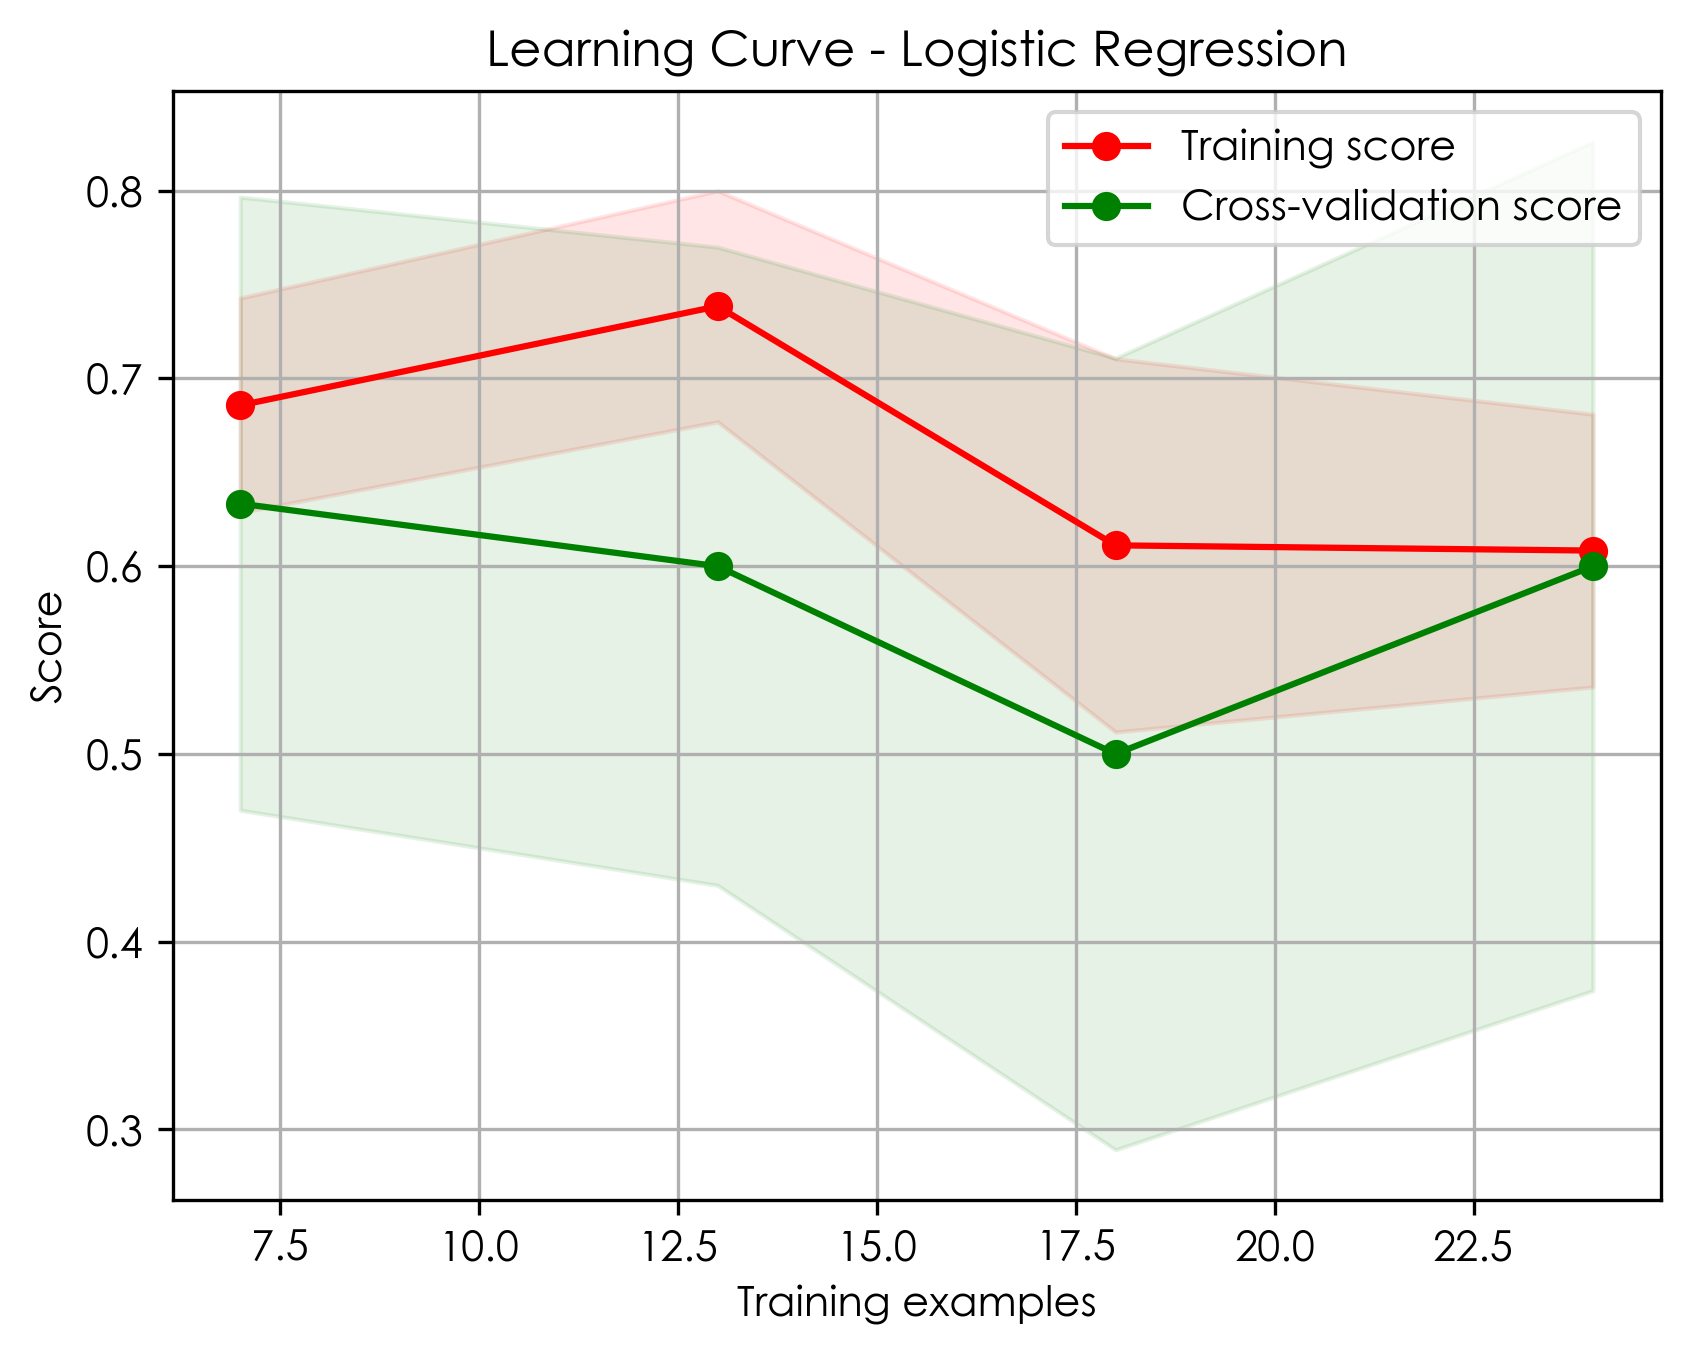

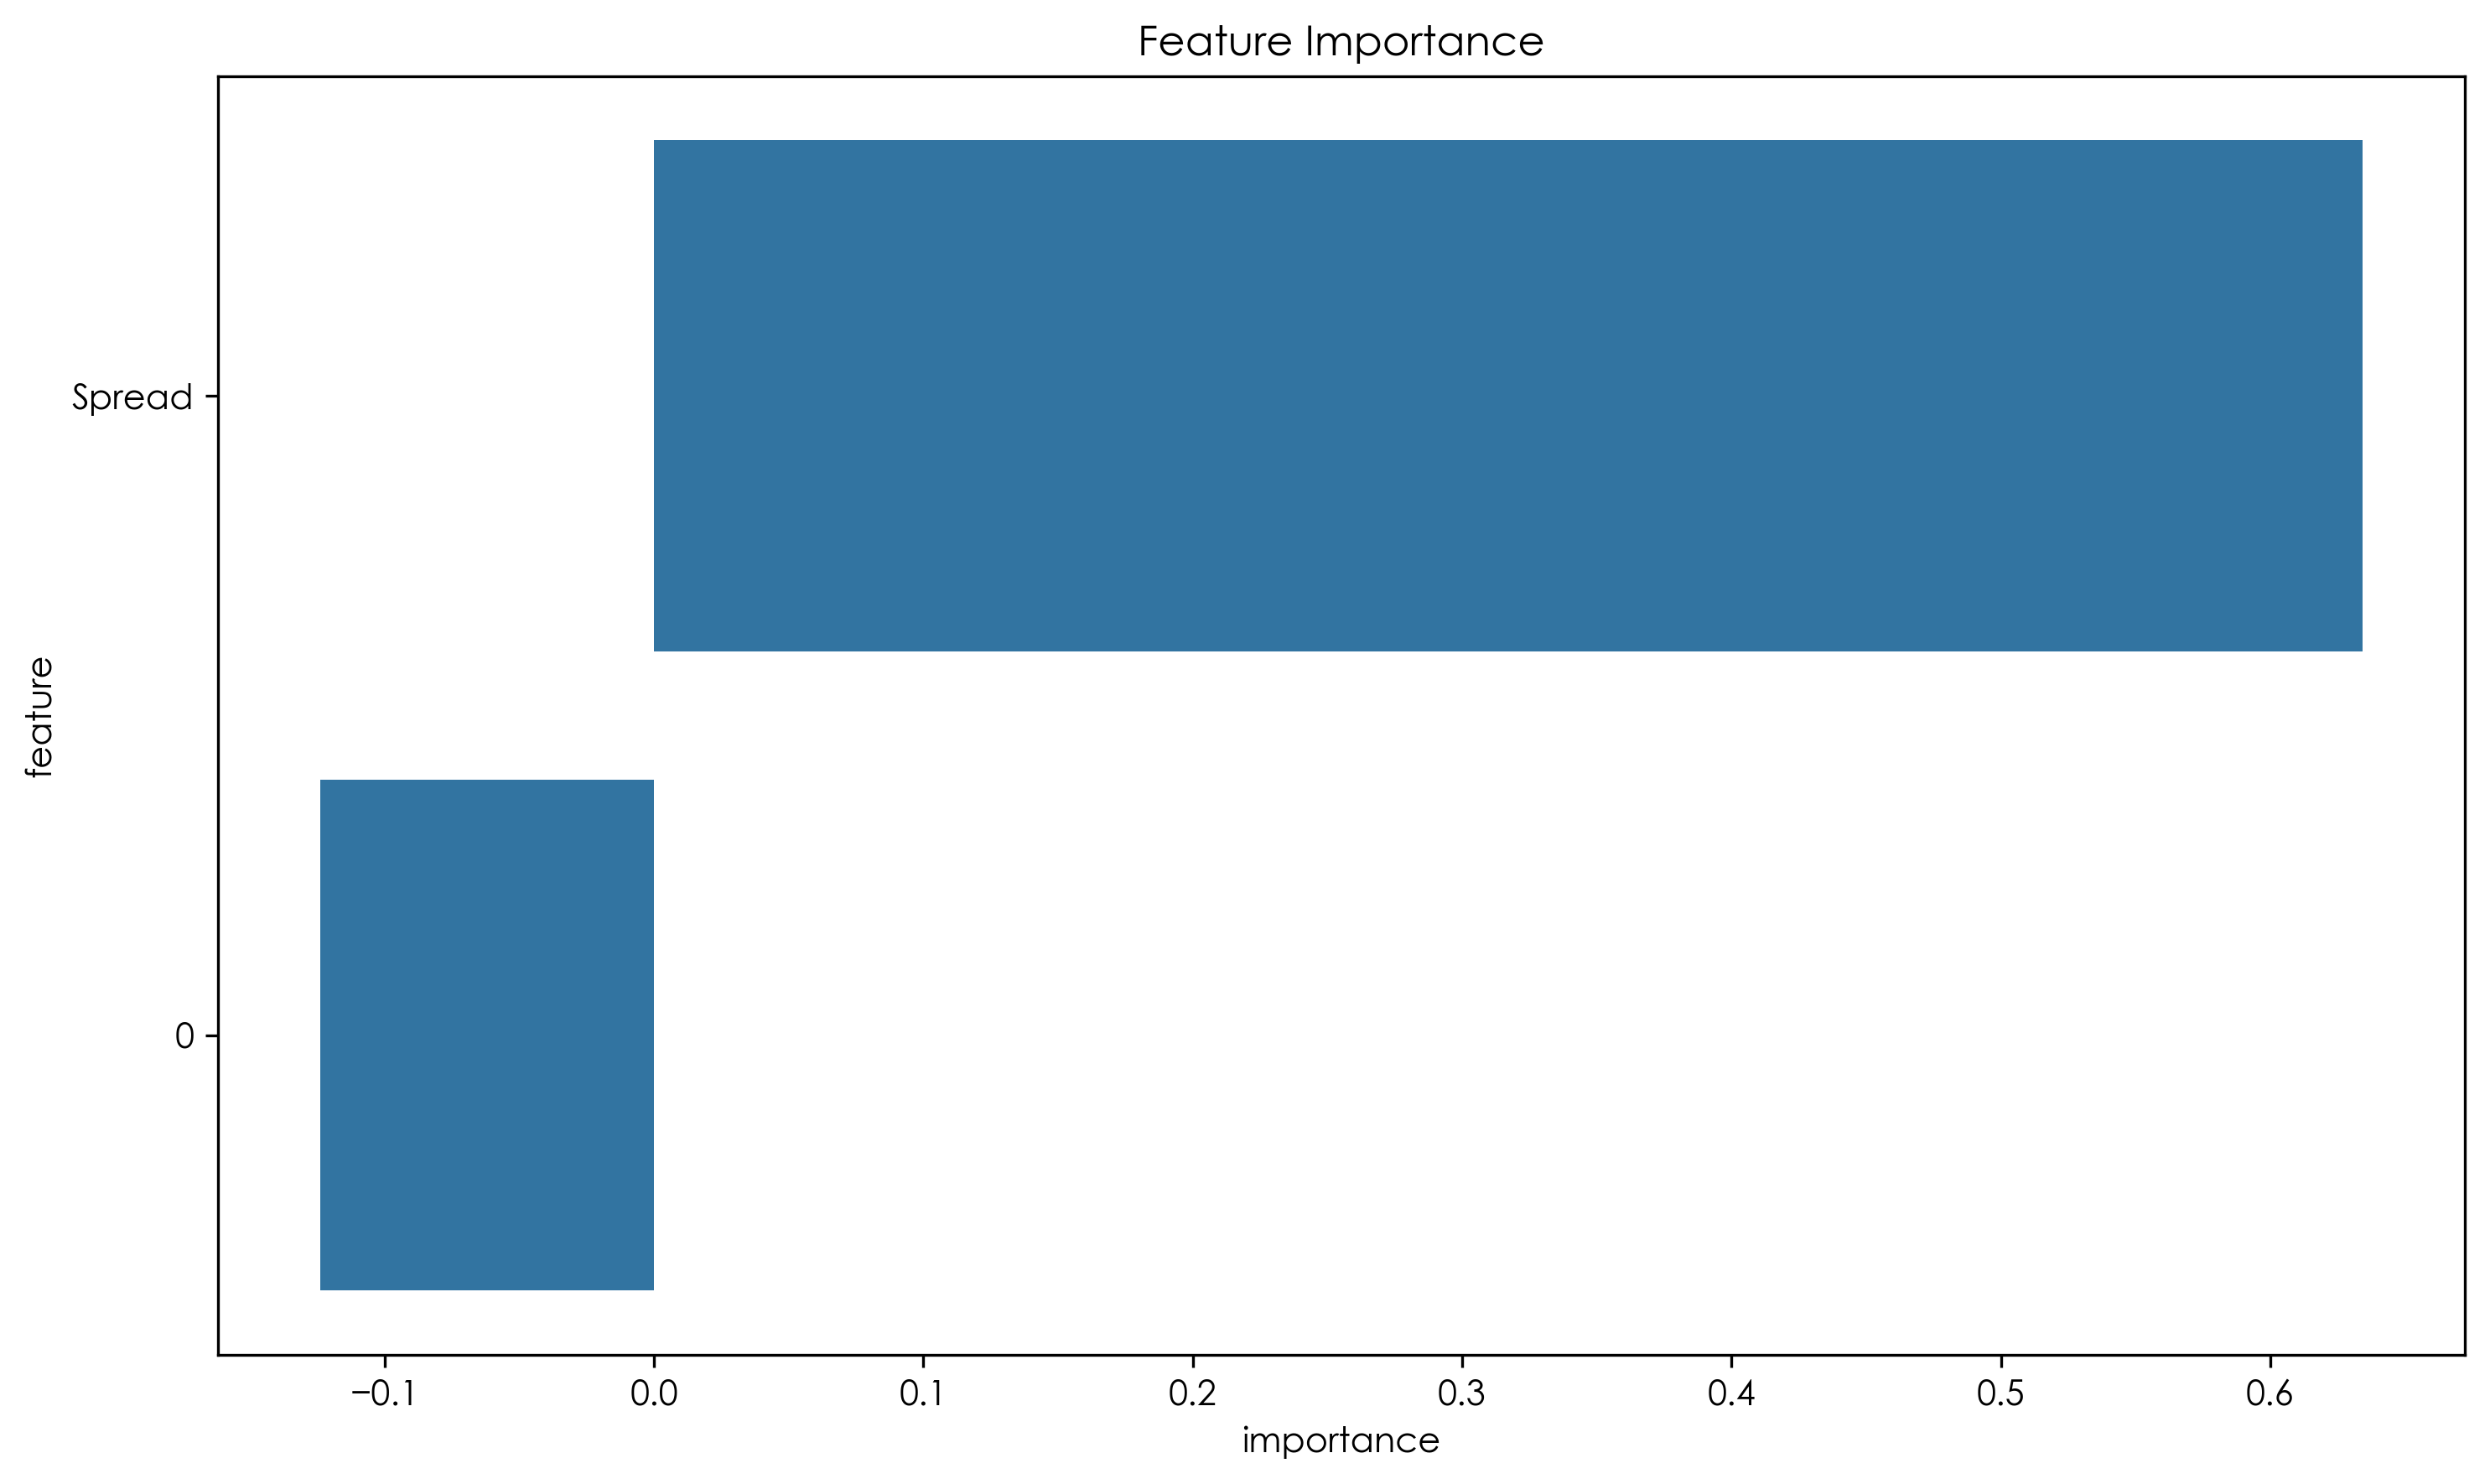


Top 5 important features:
  feature  importance
0  Spread    0.634350
1       0   -0.123833

Random Forest:
Confusion Matrix:
[[5 1]
 [3 4]]

Classification Report:
              precision    recall  f1-score   support

           0       0.62      0.83      0.71         6
           1       0.80      0.57      0.67         7

    accuracy                           0.69        13
   macro avg       0.71      0.70      0.69        13
weighted avg       0.72      0.69      0.69        13

Cross-validation F1 scores: [0.  0.  0.  0.  0.5]
Mean CV F1 score: 0.1000 (+/- 0.4000)


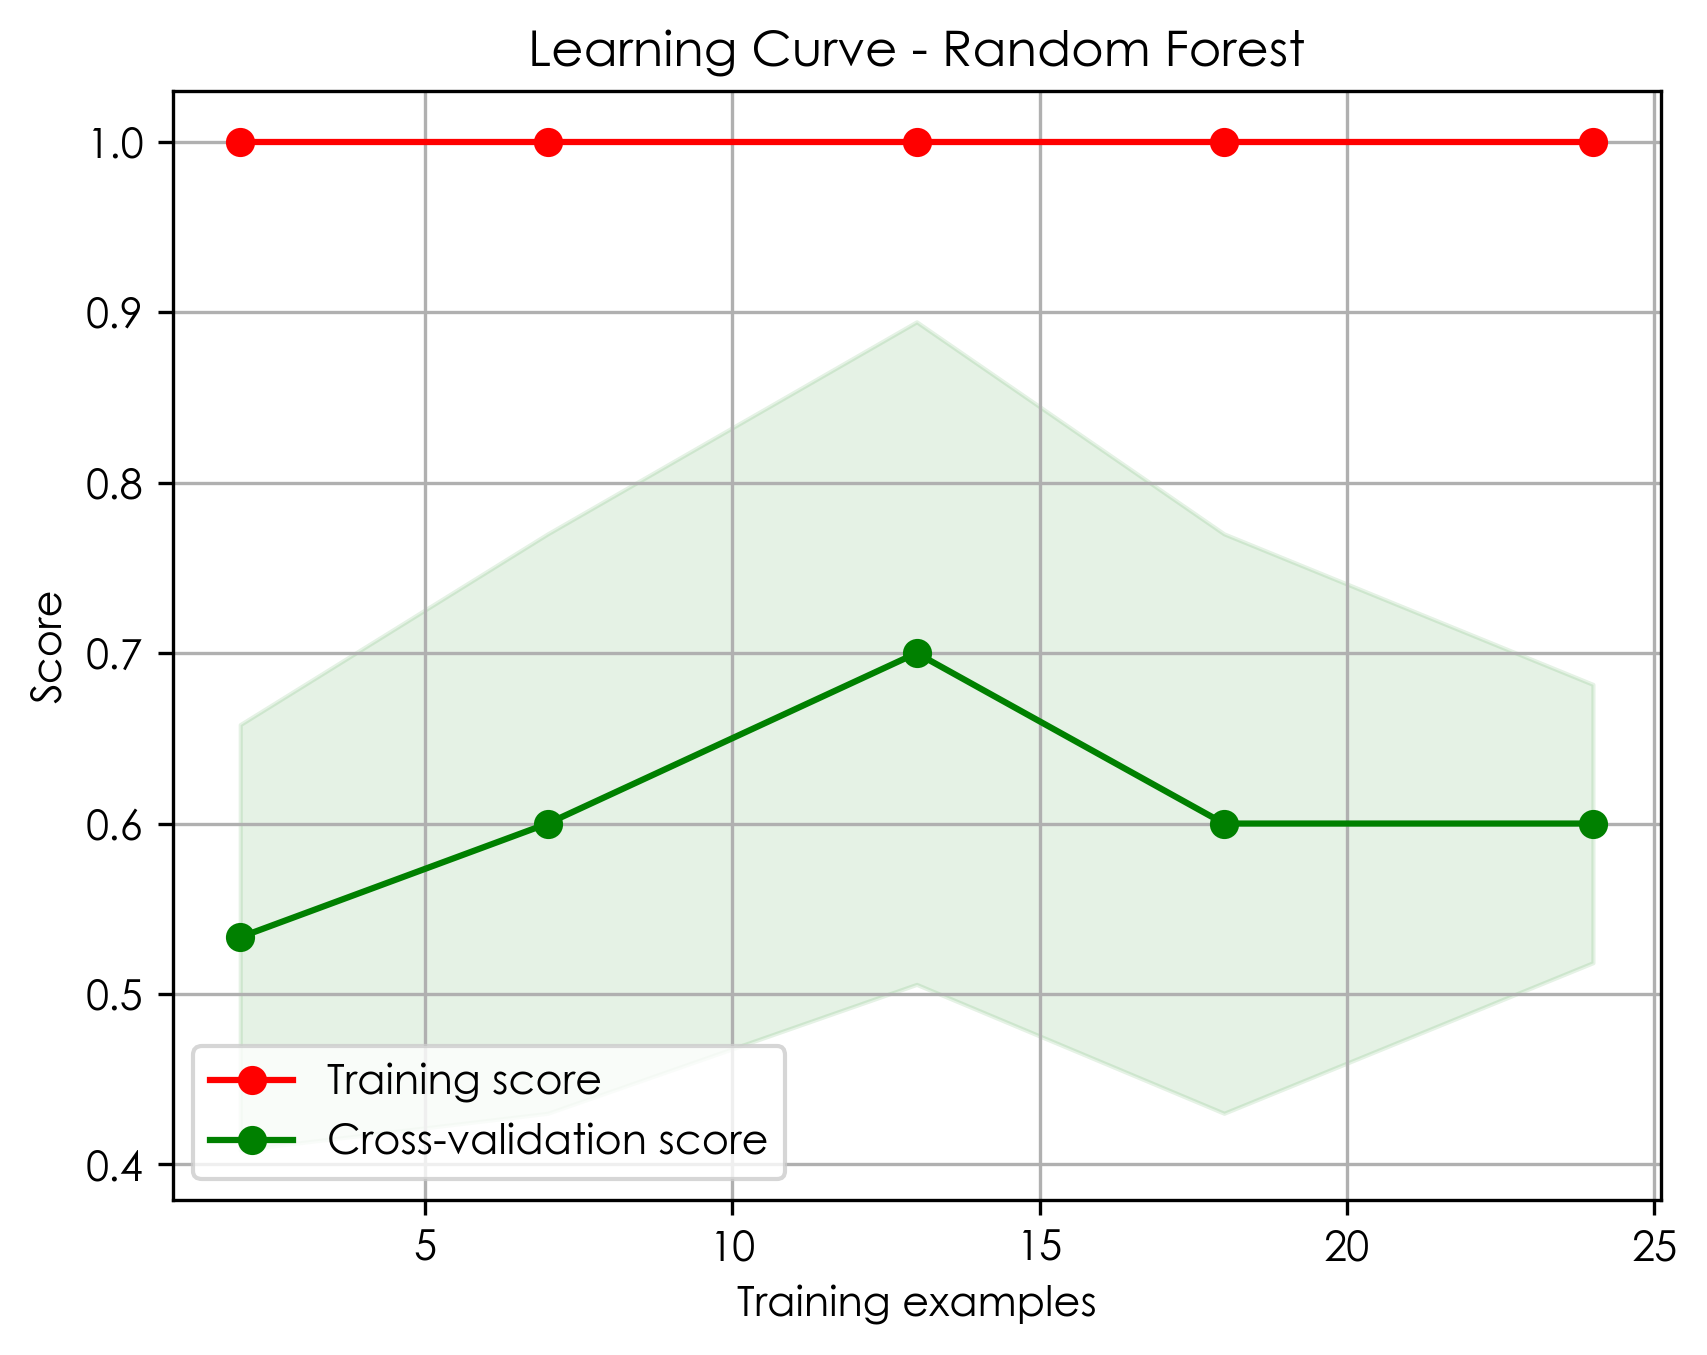

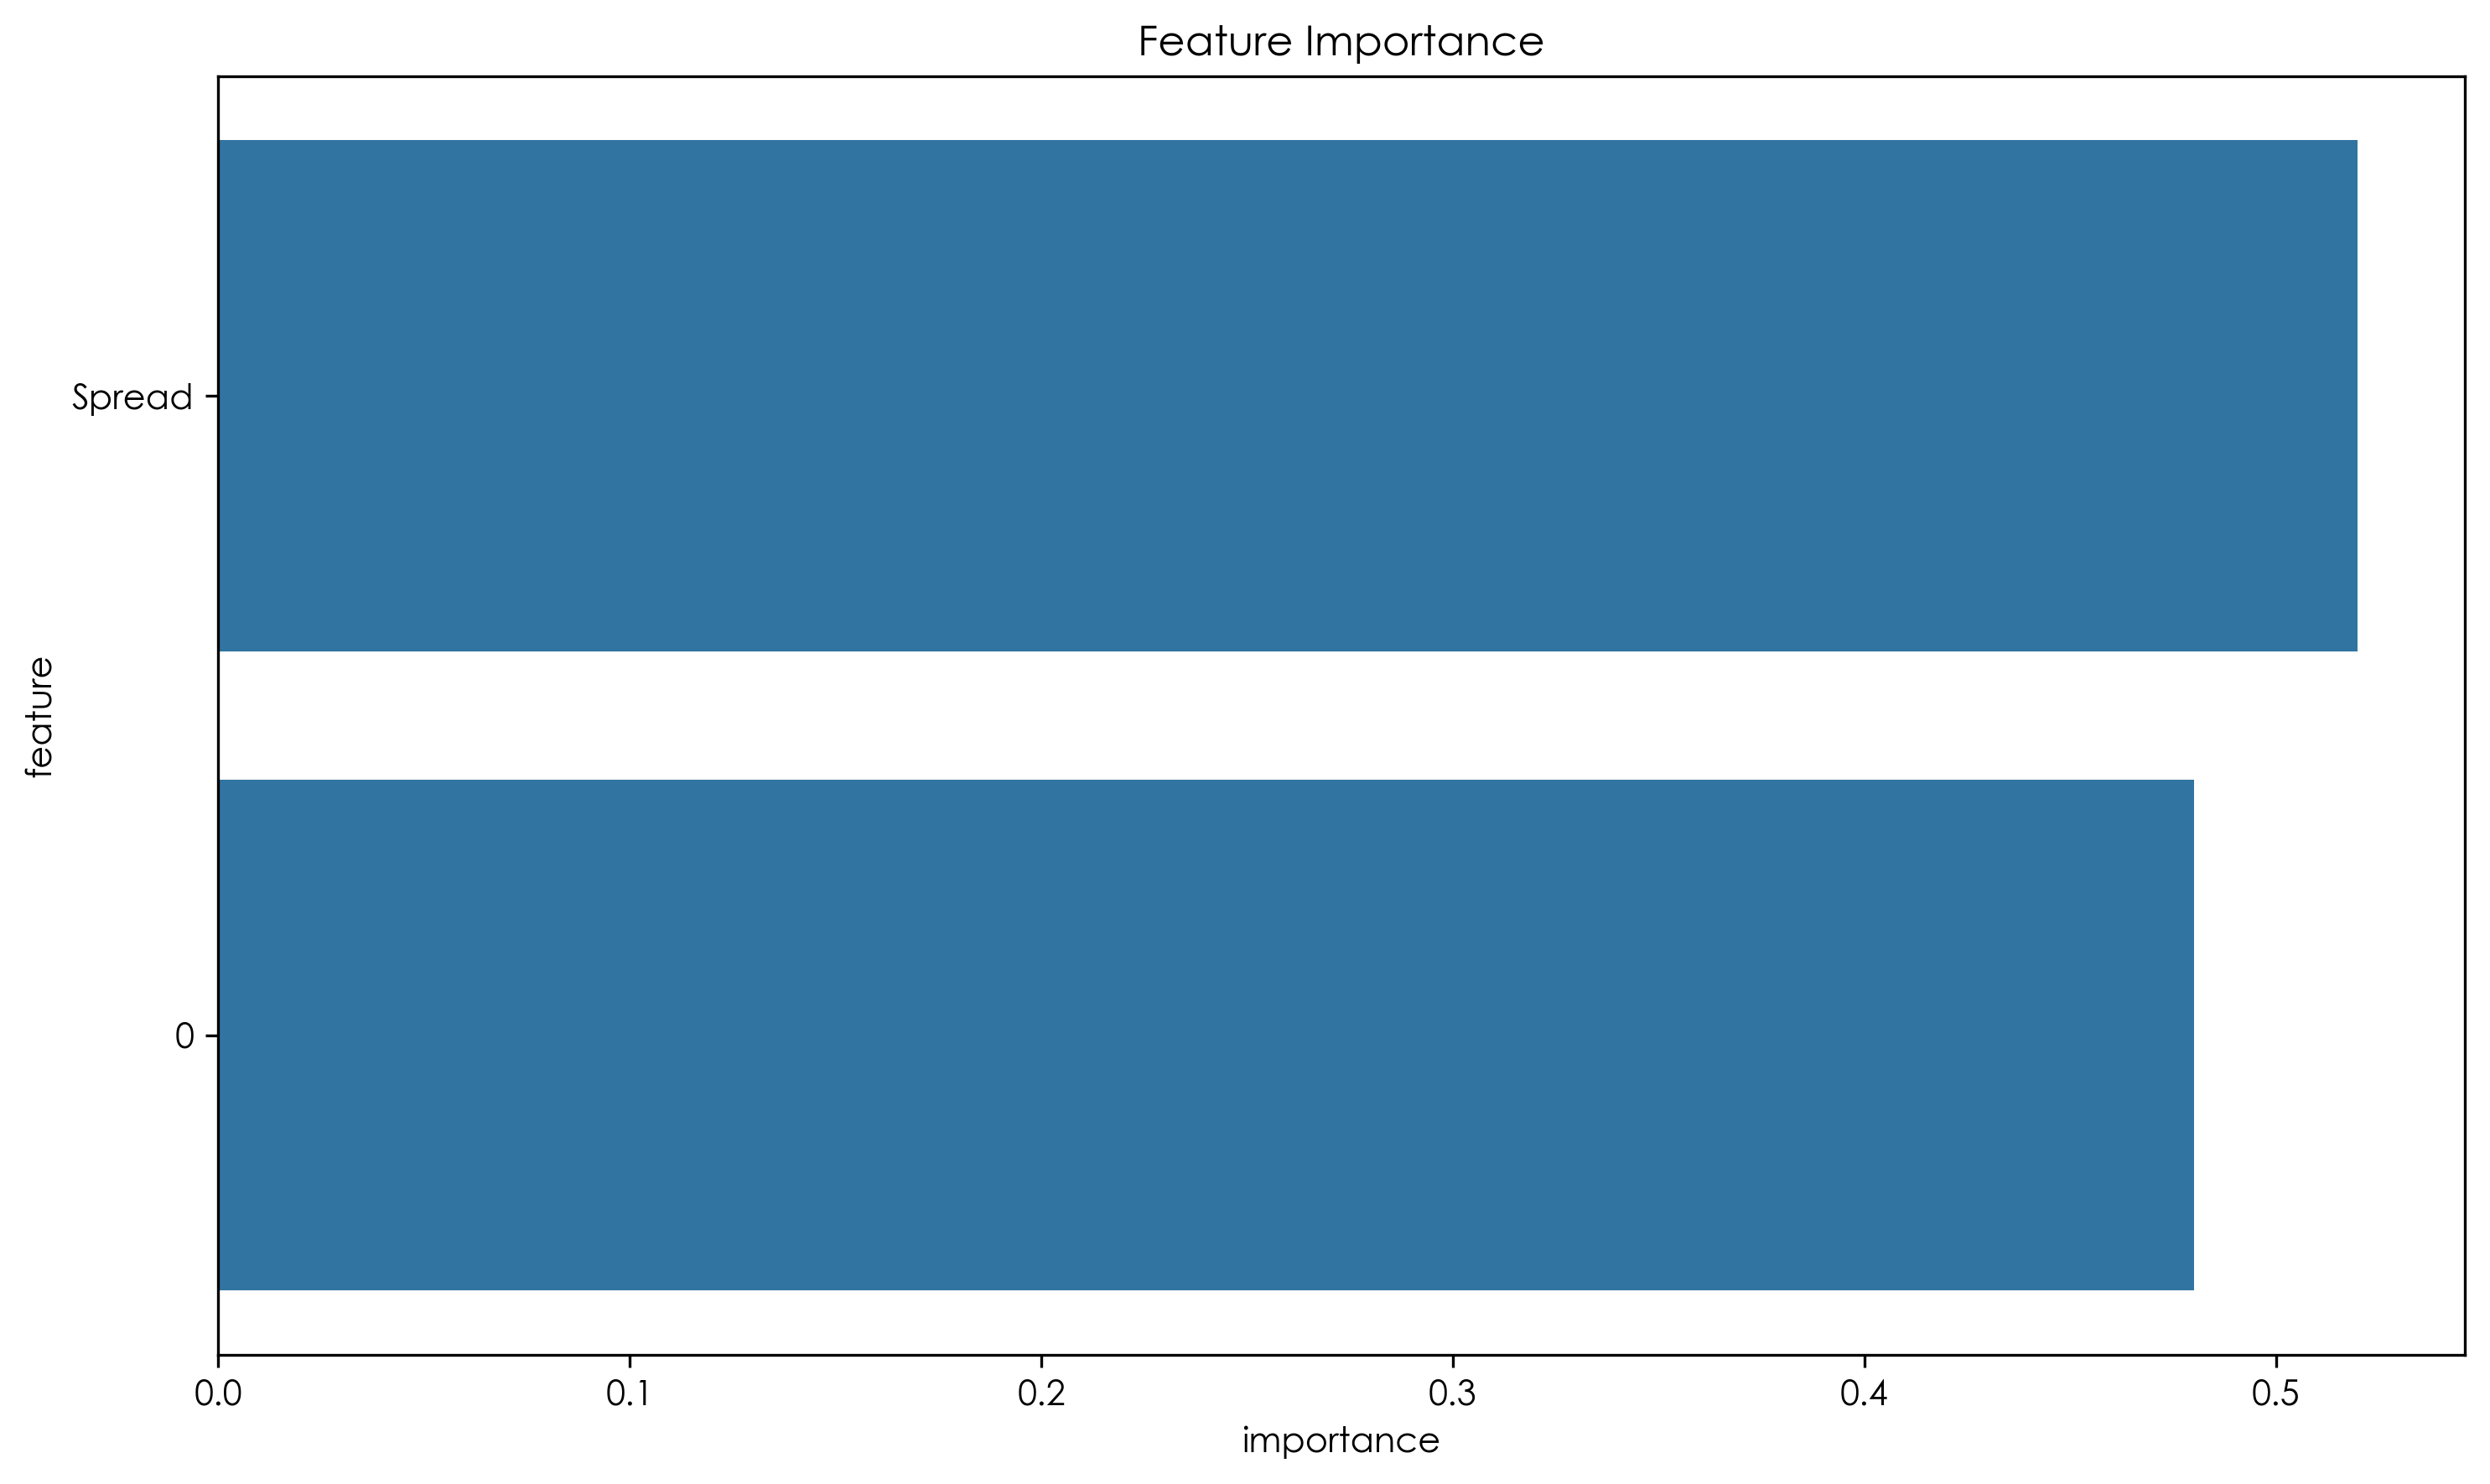


Top 5 important features:
  feature  importance
0  Spread    0.519935
1       0    0.480065

Gradient Boosting:
Confusion Matrix:
[[4 2]
 [2 5]]

Classification Report:
              precision    recall  f1-score   support

           0       0.67      0.67      0.67         6
           1       0.71      0.71      0.71         7

    accuracy                           0.69        13
   macro avg       0.69      0.69      0.69        13
weighted avg       0.69      0.69      0.69        13

Cross-validation F1 scores: [0.5 0.  0.4 0.  0.5]
Mean CV F1 score: 0.2800 (+/- 0.4630)


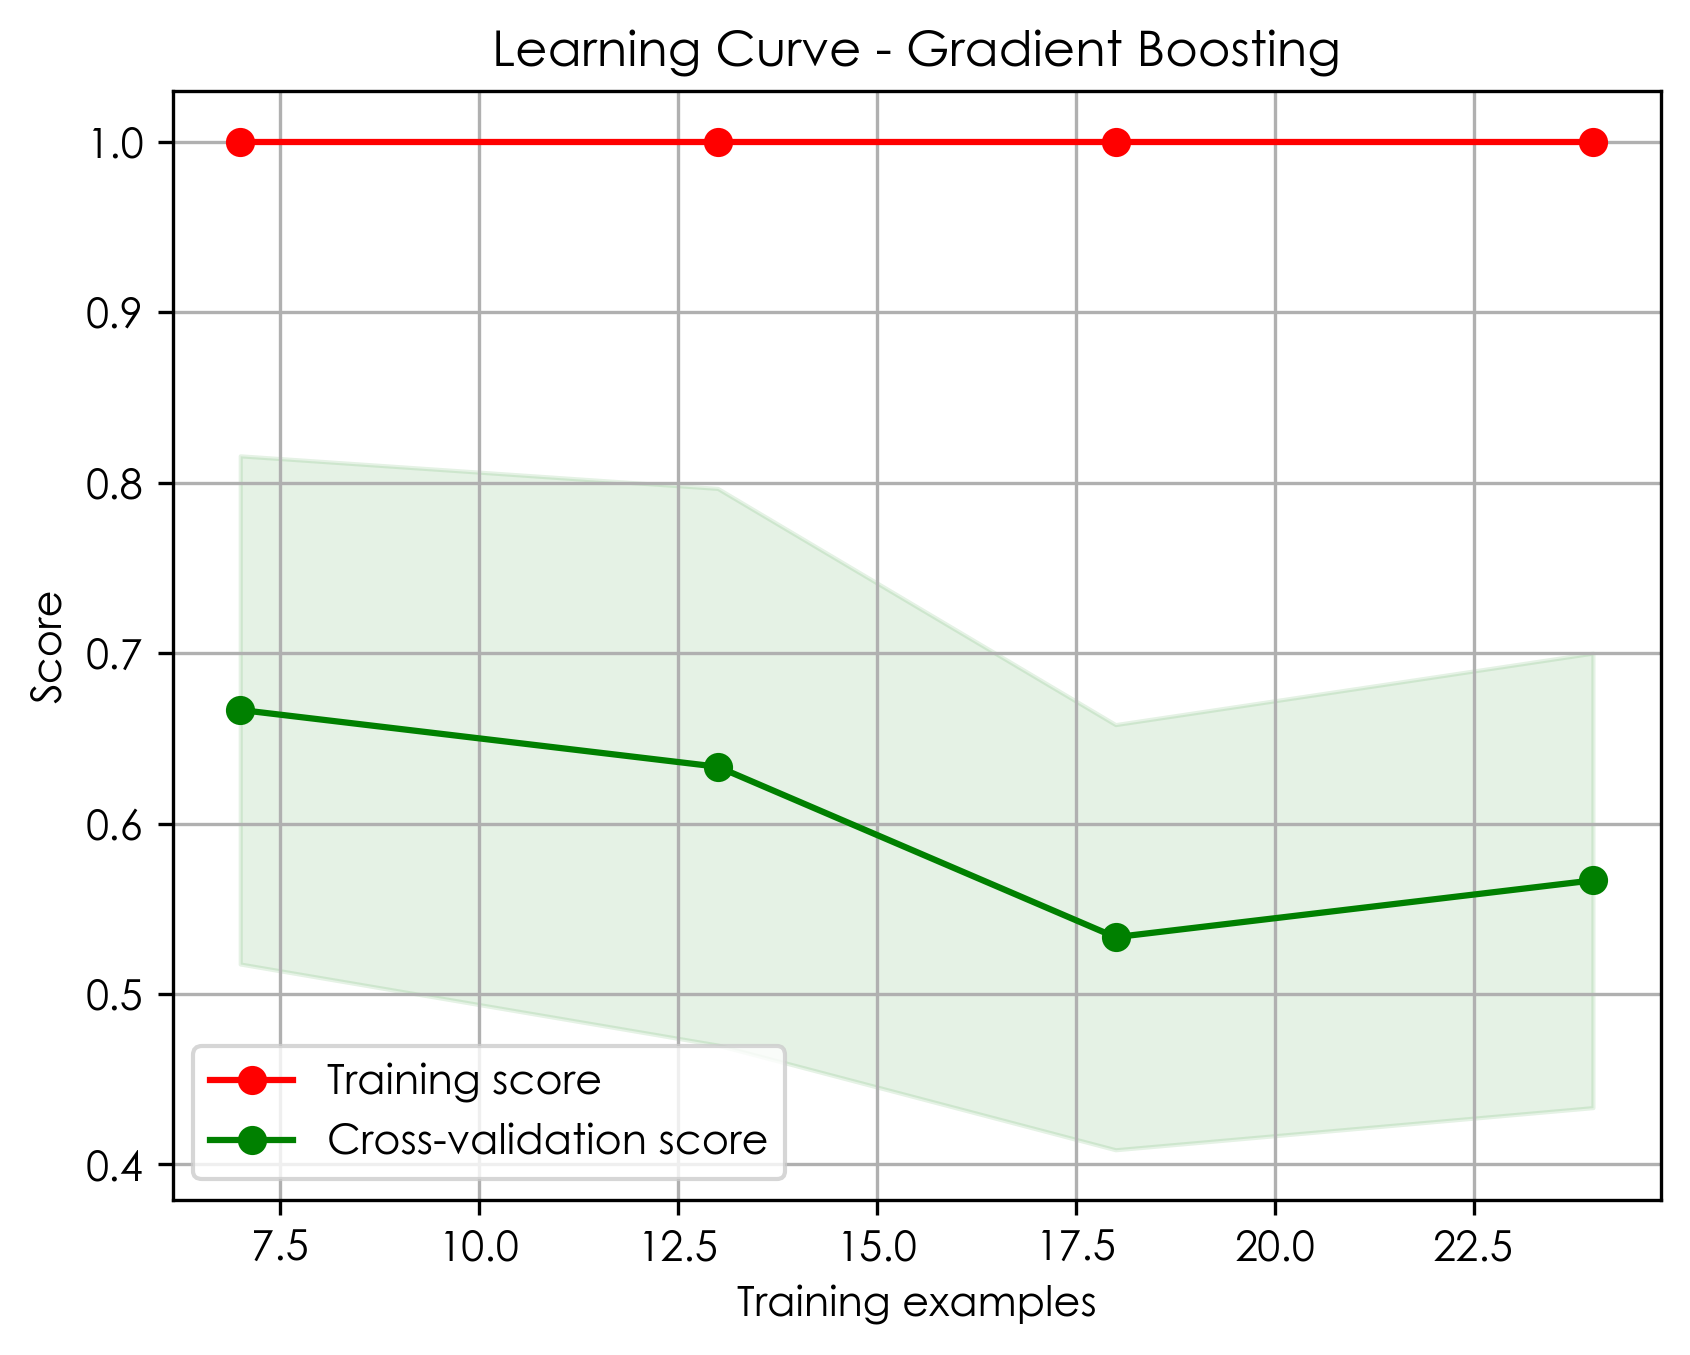

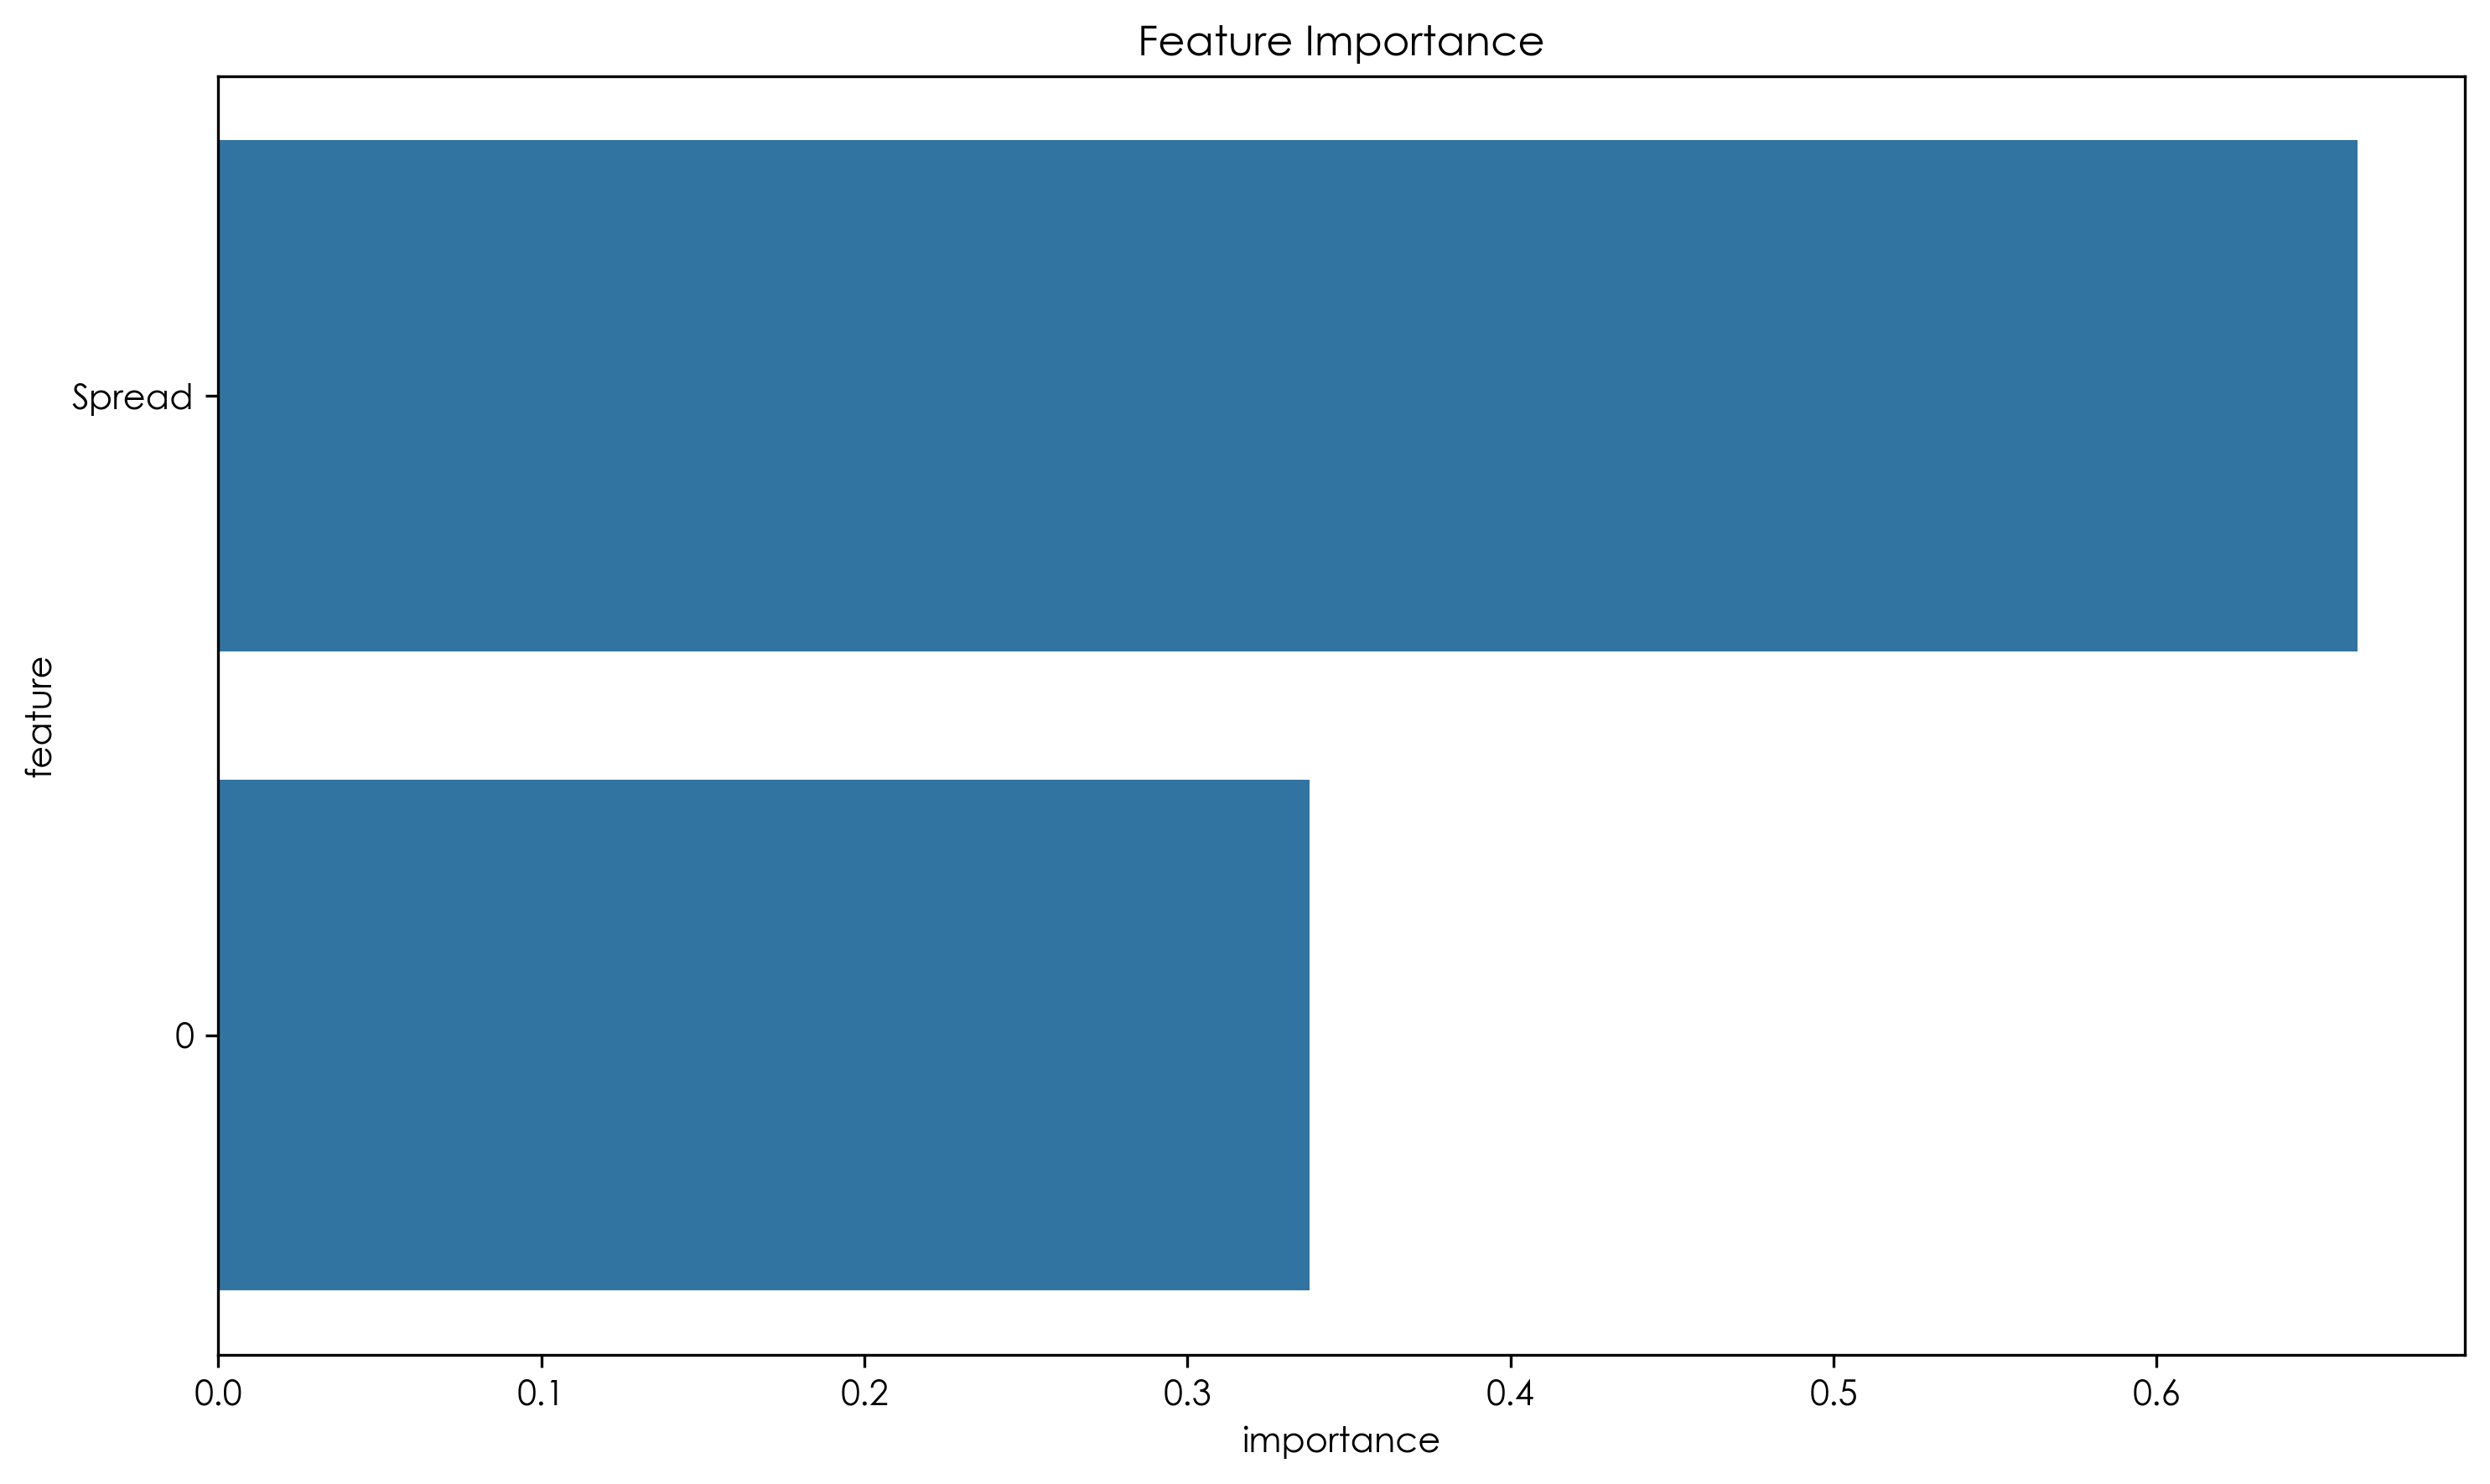


Top 5 important features:
  feature  importance
0  Spread    0.662308
1       0    0.337692


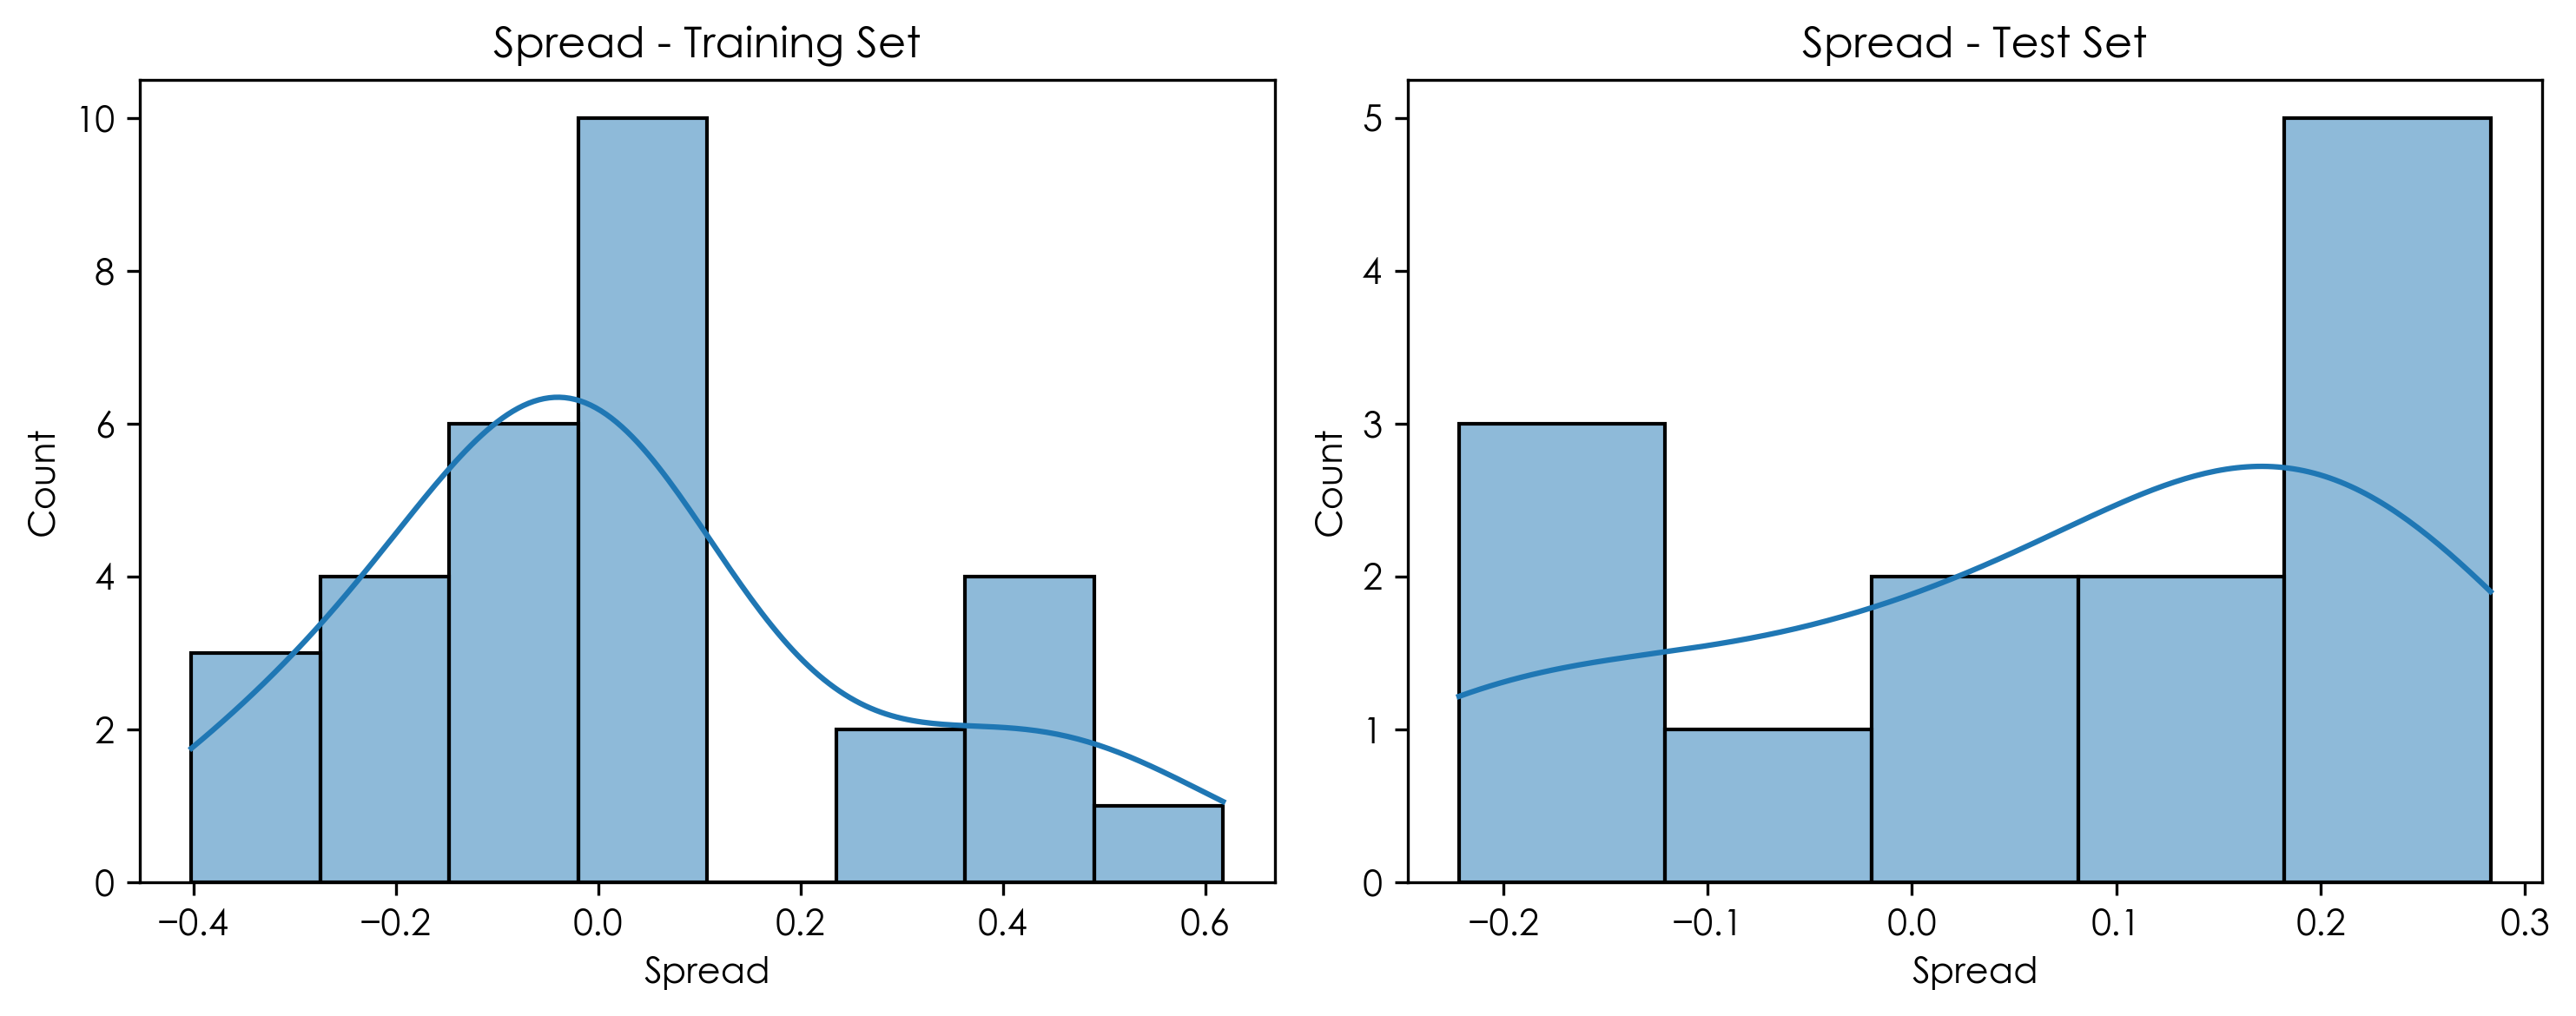

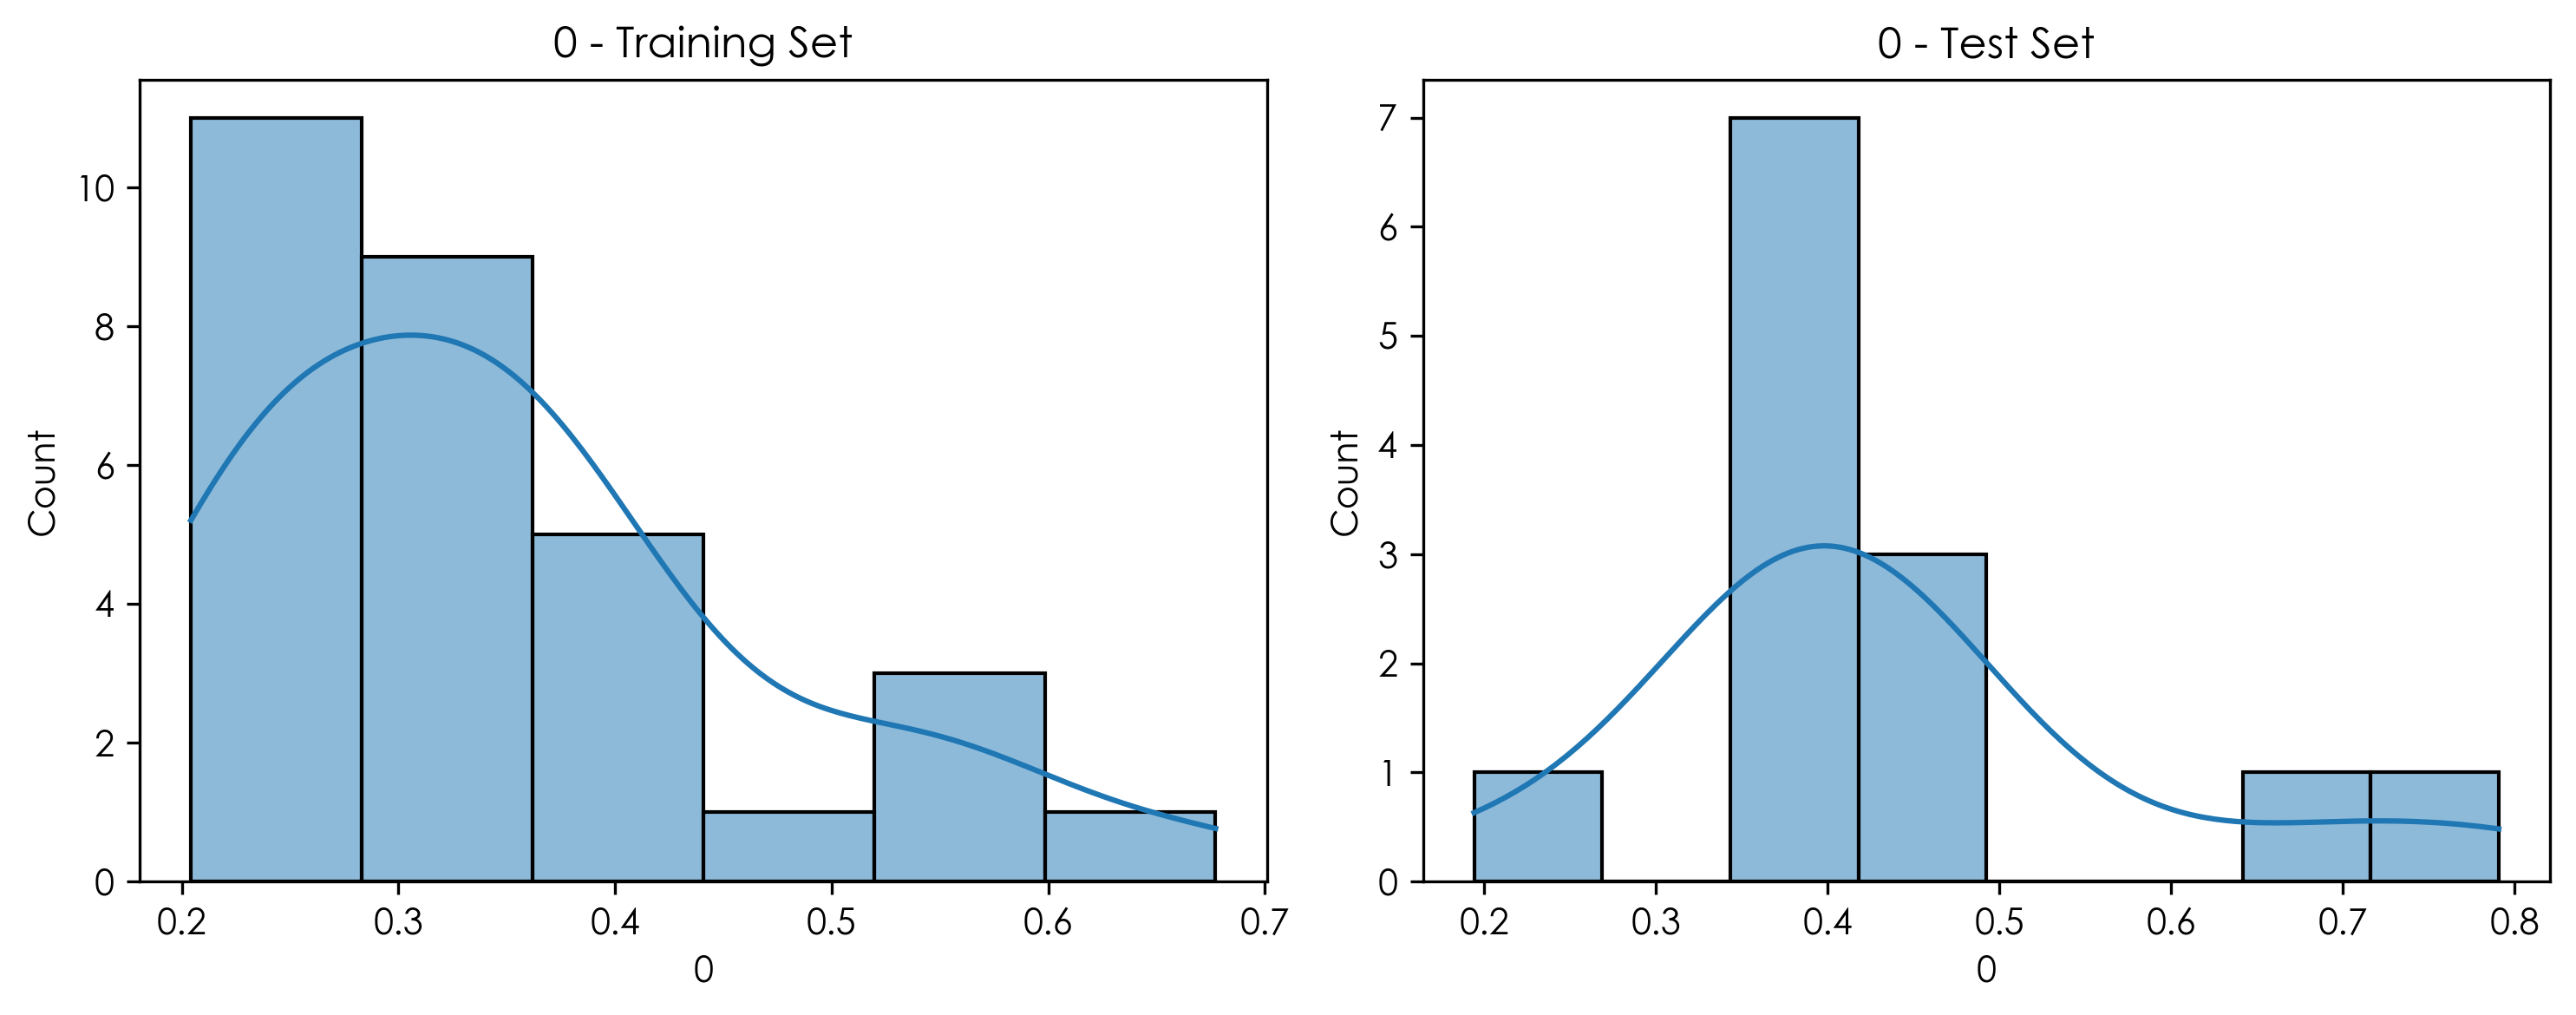


Selected features:
['Spread']

Final Model (with selected features):
Confusion Matrix:
[[4 2]
 [2 5]]

Classification Report:
              precision    recall  f1-score   support

           0       0.67      0.67      0.67         6
           1       0.71      0.71      0.71         7

    accuracy                           0.69        13
   macro avg       0.69      0.69      0.69        13
weighted avg       0.69      0.69      0.69        13


ROC AUC Score: 0.6905


In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_score, learning_curve
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import SelectFromModel
import matplotlib.pyplot as plt
import seaborn as sns

# Load the data
spread_data = pd.read_csv('election_price_spread_analysis.csv', index_col=0)
volatility_data = pd.read_csv('pre_election_volatility.csv', index_col=0)
binary_effect_data = pd.read_csv('election_effect_classification.csv', index_col=0)

# Reset index for volatility_data to match the other datasets
volatility_data = volatility_data.reset_index()
volatility_data.index = spread_data.index
volatility_data = volatility_data.drop(columns=['index'])

# Combine spread and volatility
X = pd.merge(spread_data, volatility_data, left_index=True, right_index=True, how='inner')

# Ensure all datasets have the same index
common_index = X.index.intersection(binary_effect_data.index)
X = X.loc[common_index]
y = binary_effect_data.loc[common_index, 'Effect']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Scale the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# 1. Cross-validation
def perform_cross_validation(model, X, y):
    cv_scores = cross_val_score(model, X, y, cv=5, scoring='f1')
    print(f"Cross-validation F1 scores: {cv_scores}")
    print(f"Mean CV F1 score: {np.mean(cv_scores):.4f} (+/- {np.std(cv_scores) * 2:.4f})")

# 2. Learning curves
def plot_learning_curve(estimator, X, y, title):
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=5, n_jobs=-1, train_sizes=np.linspace(.1, 1.0, 5))
    
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)

    plt.figure()
    plt.title(title)
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    plt.grid()
    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1, color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r", label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g", label="Cross-validation score")
    plt.legend(loc="best")
    plt.show()

# 3. Feature importance
def analyze_feature_importance(model, feature_names):
    importances = model.coef_[0] if hasattr(model, 'coef_') else model.feature_importances_
    feature_importance = pd.DataFrame({'feature': feature_names, 'importance': importances})
    feature_importance = feature_importance.sort_values('importance', ascending=False)
    
    plt.figure(figsize=(10, 6))
    sns.barplot(x='importance', y='feature', data=feature_importance)
    plt.title('Feature Importance')
    plt.tight_layout()
    plt.show()

    return feature_importance

# 4. Increase model complexity (using RandomForest and GradientBoosting)
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
gb_model = GradientBoostingClassifier(n_estimators=100, random_state=42)

# 5. Regularization (already handled by LogisticRegression's default settings)

# 6. Data analysis
def analyze_data_distribution(X_train, X_test):
    for column in X_train.columns:
        plt.figure(figsize=(10, 4))
        plt.subplot(1, 2, 1)
        sns.histplot(X_train[column], kde=True)
        plt.title(f'{column} - Training Set')
        plt.subplot(1, 2, 2)
        sns.histplot(X_test[column], kde=True)
        plt.title(f'{column} - Test Set')
        plt.tight_layout()
        plt.show()

# 7. Ensemble methods (already included with RandomForest and GradientBoosting)

# Train and evaluate models
models = {
    'Logistic Regression': LogisticRegression(random_state=42, class_weight='balanced', solver='liblinear'),
    'Random Forest': rf_model,
    'Gradient Boosting': gb_model
}

for name, model in models.items():
    print(f"\n{name}:")
    model.fit(X_train_scaled, y_train)
    y_pred = model.predict(X_test_scaled)
    
    print("Confusion Matrix:")
    print(confusion_matrix(y_test, y_pred))
    print("\nClassification Report:")
    print(classification_report(y_test, y_pred))
    
    perform_cross_validation(model, X_train_scaled, y_train)
    plot_learning_curve(model, X_train_scaled, y_train, f'Learning Curve - {name}')
    
    feature_importance = analyze_feature_importance(model, X.columns)
    print("\nTop 5 important features:")
    print(feature_importance.head())

# Analyze data distribution
analyze_data_distribution(X_train, X_test)

# Feature selection
selector = SelectFromModel(estimator=rf_model, prefit=False)
selector.fit(X_train_scaled, y_train)
X_train_selected = selector.transform(X_train_scaled)
X_test_selected = selector.transform(X_test_scaled)

print("\nSelected features:")
selected_features = X.columns[selector.get_support()].tolist()
print(selected_features)

# Train and evaluate model with selected features
final_model = LogisticRegression(random_state=42, class_weight='balanced', solver='liblinear')
final_model.fit(X_train_selected, y_train)
y_pred_final = final_model.predict(X_test_selected)

print("\nFinal Model (with selected features):")
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred_final))
print("\nClassification Report:")
print(classification_report(y_test, y_pred_final))

# ROC AUC score
roc_auc = roc_auc_score(y_test, final_model.predict_proba(X_test_selected)[:, 1])
print(f"\nROC AUC Score: {roc_auc:.4f}")